## Modèles Atemporel:
### Demande(quantité) par produit par magasin

In [84]:
import warnings
warnings.filterwarnings("ignore")

In [85]:
import os 
os.environ["ENV"]="LOCAL"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../store_order_service_account"
print(os.environ) 
#os.chdir("/Users/gnabeyeuemmanuel/Desktop/demandEstimate/demand-service")

environ({'NV_LIBCUBLAS_DEV_VERSION': '11.3.0.106-1', 'NV_CUDA_COMPAT_PACKAGE': 'cuda-compat-11-1', 'NV_CUDNN_PACKAGE_DEV': 'libcudnn8-dev=8.0.5.39-1+cuda11.1', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.8.4-1+cuda11.1', 'CLOUDSDK_PYTHON': 'python3', 'LANG': 'en_US.UTF-8', 'NV_LIBNPP_DEV_PACKAGE': 'libnpp-dev-11-1=11.1.2.301-1', 'HOSTNAME': '6ab912303826', 'OLDPWD': '/', 'CLOUDSDK_CONFIG': '/content/.config', 'NV_LIBNPP_VERSION': '11.1.2.301-1', 'NV_NVPROF_DEV_PACKAGE': 'cuda-nvprof-11-1=11.1.105-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'NV_NVPROF_VERSION': '11.1.105-1', 'NV_LIBCUSPARSE_VERSION': '11.3.0.10-1', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=172.28.0.2"],"debugAdapterMultiplexerPath":"/usr/local/bin/dap_multiplexer","enableLsp":true}', 'NV_LIBCUBLAS_DEV_PACKAGE': 'libcublas-dev-11-1=11.3.0.106-1', 'ENV': 'LOCAL', 'NCCL_VERSION': '2.8.4-1

### 1. Import usefull libraries

In [86]:
import os
import sys
import sys; 
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
from sklearn.cluster import KMeans
#import pandasgui

%matplotlib inline
#import google.cloud.secretmanager as secretmanager

#from utils.utility_fct import get_table_sql,cross_product

from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

import time
import datetime
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
#from french_holidays import get_french_holiday_calendar

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

### 2. Load and Plot the time series dataset

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
path = '/content/drive/MyDrive/Data/demandes.csv'
series1 = pd.read_csv(path)
series1=series1[['store_id',	'product_id',	'product_count',	'time']]
series1.columns=['store_id',	'product_id',	'product_count',	'date']
#series1.columns=['store_id',	'product_id',	'product_count',	'date']
series1.head()

,store_id,product_id,product_count,date
0,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-03
1,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-05
2,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,2.0,2022-02-09
3,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-10
4,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,2.0,2022-02-13


In [89]:
series2 = pd.read_csv('/content/drive/MyDrive/Data/products_movements.csv', header=0) 
print(series2.columns)
series2=series2[['store_id',	'product_id',	'start_date', 'end_date']]

series2.tail()

Index(['Unnamed: 0', 'store_id', 'product_id', 'start_date', 'end_date'], dtype='object')


,store_id,product_id,start_date,end_date
13579,62b1e32b1b95a10016871dab,62c6ecdd00fdf50011e3bb4b,2022-08-11 21:46:20.781000+00:00,2022-08-25 03:00:29.030000+00:00
13580,62b1e32b1b95a10016871dab,62c713101310330011e6bc44,2022-08-11 21:46:21.033000+00:00,2022-09-08 08:11:22.414586+00:00
13581,62b1e32b1b95a10016871dab,62f1174fa22ad500119dab88,2022-08-25 03:00:29.030000+00:00,2022-09-08 08:11:22.414586+00:00
13582,62b1e32b1b95a10016871dab,6306515f78a729001198361a,2022-09-01 04:24:15.213000+00:00,2022-09-08 08:11:22.414586+00:00
13583,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213000+00:00,2022-09-08 08:11:22.414586+00:00


In [90]:
#series1 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/demande.csv', header=0) #index_col=0
#series2 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/product_movements.csv', header=0) #.iloc[20:,:] 
#series1.head() 

In [91]:
series1.describe()

,product_count
count,382625.000000
mean,1.515277
std,1.031670
min,-0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,20.000000


In [92]:
print(series2.columns)
series2.tail()

Index(['store_id', 'product_id', 'start_date', 'end_date'], dtype='object')


,store_id,product_id,start_date,end_date
13579,62b1e32b1b95a10016871dab,62c6ecdd00fdf50011e3bb4b,2022-08-11 21:46:20.781000+00:00,2022-08-25 03:00:29.030000+00:00
13580,62b1e32b1b95a10016871dab,62c713101310330011e6bc44,2022-08-11 21:46:21.033000+00:00,2022-09-08 08:11:22.414586+00:00
13581,62b1e32b1b95a10016871dab,62f1174fa22ad500119dab88,2022-08-25 03:00:29.030000+00:00,2022-09-08 08:11:22.414586+00:00
13582,62b1e32b1b95a10016871dab,6306515f78a729001198361a,2022-09-01 04:24:15.213000+00:00,2022-09-08 08:11:22.414586+00:00
13583,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213000+00:00,2022-09-08 08:11:22.414586+00:00


In [93]:
def preprocessing(df1:pd.DataFrame, df2:pd.DataFrame):
    df2['start_date'] = pd.to_datetime(df2['start_date'], utc=True).dt.tz_localize(None)
    df2['end_date'] = pd.to_datetime(df2['end_date'], utc=True).dt.tz_localize(None)

    # start since the 1st january 2022
    ref = datetime.datetime(2022, 1, 1)

    index_names = df2[df2['end_date'] < ref].index
    df2.drop(index_names, inplace=True)
        #for i in df2.index:
        #    if df2['start_date'][i] < ref:
        #        df2['start_date'][i] = ref

        # Create intermediates Dates over the presence of products in the different stores
    df2["date"] = df2.apply(lambda x: pd.date_range(x.start_date, x.end_date), axis=1)
    df2 = df2.explode('date').reset_index(drop=True)
    df2['date'] = df2['date'].dt.date
    df1['date'] = pd.to_datetime(df1.date).dt.date
    df = df1.merge(df2, how='right', on=['date', 'store_id', 'product_id']).fillna({'product_count': 0})
   
    df=df.dropna()
    df.drop(df.columns[[4, 5]], axis=1,
                     inplace=True)  # df.drop(df.loc[:, 'start_date ':'end_date '].columns, axis = 1)
        ## Let's create a matrix with one row per time step and one column per product per store
   
    print(type(df))
    table = pd.pivot_table(df, values='product_count', index=['date'],
                               columns=['product_id', 'store_id'],
                               aggfunc=np.sum)  # fill_value !=0 here
        # fillna() On = 'average quantity of each product over the all data'
    tab = df.loc[:, ['product_id', 'product_count']].groupby('product_id').mean()
    filler = pd.DataFrame(index=table.index, columns=table.columns)

    for id_product, id_store in filler.columns:
            filler[(id_product, id_store)] = tab.loc[id_product, 'product_count']
    table = table.fillna(filler)
        ## Pre-process the input data
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    input_data = pd.concat([
            df['date'].dt.day,
            # df['date'].dt.month,
            df['date'].dt.weekday,
            df['date'].dt.weekofyear,
        ], axis=1).drop_duplicates()
    input_data.columns = ['day', 'weekday', 'weekofyear']
    return input_data, table


In [94]:
def standardization(y_train):
        # Choose between standardization and MinMAx normalization
   scaler = StandardScaler()
        # Storing the fit object for later reference
   scaler = scaler.fit(y_train)
        # Generating the standardized values of X
   yhat = scaler.transform(y_train)
   return scaler, yhat

def splitting(x, table, test_size = 0.2):
    n = x.shape[0]
    m = table.shape[0]
    x_train = x[0:math.floor((1 - test_size) * n)]
    x_test = x[math.floor((1 - test_size) * n):n + 1]
    y_train = table[0:math.floor((1 - test_size) * m)]
    y_test = table[math.floor((1 - test_size) * m):m + 1]
    return  x_train, x_test, y_train,y_test

In [95]:
def metrics_(orig, prediction):
   mse = mean_squared_error(y_true=orig,
                                         y_pred=prediction)
   mae = mean_absolute_error(y_true=orig,
                                          y_pred=prediction)
   ms_le = mean_squared_log_error(y_true=np.abs(orig),
                                              y_pred=np.abs(prediction))
   metric = dict()
   metric['MSE'] = mse
   metric['MAE'] = mae
   metric['MSLE'] = ms_le
   return metric

In [96]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
    ## Load the data
#demand=series1, product_movements = series2

        ## Preprocessing the data
x, table = preprocessing(series1, series2)

        ### splitting the data
x_train, x_test, y_train, y_test = splitting(x, table, 0.2)

        ### Normalise the output train set
scaler, yhat = standardization(y_train)


    ## PCA over the output per product per store
n_pca=5
my_pca = PCA(n_components=n_pca)
principal_component = my_pca.fit_transform(yhat)
columns = ['PC' + str(i) for i in range(n_pca)]
y_train = pd.DataFrame(data=principal_component, columns=columns)
        

    ## Fit the model over the Principal component
sv_regressor = svm.SVR(C=50, kernel='rbf', gamma=0.01)  # or LinearSVR() #
mul_regressor = MultiOutputRegressor(sv_regressor)

        # Printing all the parameters
print(mul_regressor)
        # Creating the model on Training Data
svm_model = mul_regressor.fit(x_train, y_train)
        

        #Make a test
prediction = svm_model.predict(x_test)
        ## PCA and Standardization Inversion (Transform data back to its original space.)
predict = scaler.inverse_transform(my_pca.inverse_transform(prediction))
        # Measuring Goodness of fit in Testing data 'MSE: %.3f' % MSE
print('R2 Value for n_pca=: %i' % n_pca, metrics.r2_score(y_test, predict))
print(metrics_(y_test, predict))
     


<class 'pandas.core.frame.DataFrame'>
MultiOutputRegressor(estimator=SVR(C=50, gamma=0.01))
R2 Value for n_pca=: 5 -1.1251278970845766e+29
{'MSE': 0.3763235595766846, 'MAE': 0.26113813296740385, 'MSLE': 0.08428729659181333}


In [97]:
x

,day,weekday,weekofyear
0,28,0,40
1,29,1,40
2,30,2,40
3,1,3,40
4,2,4,40
...,...,...,...
706,4,6,35
707,5,0,36
708,6,1,36
709,7,2,36


In [98]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df1=pd.DataFrame() 
    #début à partir du 1er janvier 2022   .strftime('%Y-%m-%d')
    ref=datetime.datetime(2022,1,1)
    indexNames = df[df['end_date'] < ref].index
    df.drop(indexNames , inplace=True)
    for i in df.index:
        if df['start_date'][i] < ref:
            df['start_date'][i] = ref
            
    #Dates intermédiaires sur la présence des produits dans le magassin
    df["date"] = df.apply(lambda x: pd.date_range(x.start_date, x.end_date), axis=1)
    df = df.explode('date').reset_index(drop=True)
    df['date']=df['date'].dt.date
        
    return df
    

In [99]:
series2['start_date']= pd.to_datetime(series2['start_date'],utc=True).dt.tz_localize(None)
series2['end_date']= pd.to_datetime(series2['end_date'],utc=True).dt.tz_localize(None)

df_pro=preprocess(series2)
df_pro

,store_id,product_id,start_date,end_date,date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-01
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-02
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-03
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-04
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-05
...,...,...,...,...,...
1724230,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586,2022-09-04
1724231,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586,2022-09-05
1724232,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586,2022-09-06
1724233,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586,2022-09-07


In [100]:
series1['date'] = pd.to_datetime(series1.date).dt.date
series3=series1.merge(df_pro, how='right', on=['date','store_id','product_id']).fillna({'product_count':0})
series3

,store_id,product_id,product_count,date,start_date,end_date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-01,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-02,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-03,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-04,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-05,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
...,...,...,...,...,...,...
1724230,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-04,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586
1724231,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-05,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586
1724232,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-06,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586
1724233,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-07,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586


In [101]:
series3.dtypes

store_id                 object
product_id               object
product_count           float64
date                     object
start_date       datetime64[ns]
end_date         datetime64[ns]
dtype: object

In [102]:
df=series3.dropna()
df.drop(df.columns[[4, 5]], axis = 1, inplace = True) #df.drop(df.loc[:, 'start_date ':'end_date '].columns, axis = 1) 
df

,store_id,product_id,product_count,date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-01
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-02
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-03
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-04
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-01-05
...,...,...,...,...
1724230,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-04
1724231,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-05
1724232,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-06
1724233,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-07


##### PCA sur series3/df par produit/magassin

##### création d'une matrice avec une ligne par pas de temps et une colonne par produit/magasin

In [103]:
table =pd.pivot_table(df, values='product_count', index=['date'],
            columns=['product_id', 'store_id'], 
            aggfunc=np.sum) #, fill_value=0) # nan ou fillna= moyenne de la colonne

In [104]:
# fillna() On = 'average quantity of each product over the 6 months'
tab=df.loc[:, ['product_id', 'product_count']].groupby('product_id').mean()
filler = pd.DataFrame(index = table.index, columns = table.columns)
for id_produit,id_store in filler.columns:
    filler[(id_produit,id_store)]=tab.loc[id_produit, 'product_count'] 

In [105]:
table=table.fillna(filler)
table.head()

product_id 5cebfa8d0b259700045dc8a9 5cebfa8d0b259700045dc8aa  \
store_id   5d5d24216115b3000435fa24 5d5d24216115b3000435fa24   
date                                                           
2022-01-01                      0.0                      0.0   
2022-01-02                      0.0                      0.0   
2022-01-03                      0.0                      0.0   
2022-01-04                      0.0                      0.0   
2022-01-05                      0.0                      0.0   

product_id                                                    \
store_id   5f1198de8746ae00042869ba 5f60c3bbf4ff730004b46600   
date                                                           
2022-01-01                 0.155846                 0.155846   
2022-01-02                 0.155846                 0.155846   
2022-01-03                 0.155846                 0.155846   
2022-01-04                 0.155846                 0.155846   
2022-01-05                 0.155846                 0.155846   

product_id                                                    \
store_id   5f898d328fd8fa000492a14d 5fca2dbdabdffb0004e1d05a   
date                                                           
2022-01-01                 0.155846                 0.155846   
2022-01-02                 0.155846                 0.155846   
2022-01-03                 0.155846                 0.155846   
2022-01-04                 0.155846                 0.155846   
2022-01-05                 0.155846                 0.155846   

product_id                                                    \
store_id   5fe3228d8babb6001700452b 5fe32734d1c92d0017c555f3   
date                                                           
2022-01-01                 0.155846                 0.155846   
2022-01-02                 0.155846                 0.155846   
2022-01-03                 0.155846                 0.155846   
2022-01-04                 0.155846                 0.155846   
2022-01-05                 0.155846                 0.155846   

product_id                                                    ...  \
store_id   603ceebac776ee00150cfb2d 603f6417954a0c00152089e6  ...   
date                                                          ...   
2022-01-01                 0.155846                 0.155846  ...   
2022-01-02                 0.155846                 0.155846  ...   
2022-01-03                 0.155846                 0.155846  ...   
2022-01-04                 0.155846                 0.155846  ...   
2022-01-05                 0.155846                 0.155846  ...   

product_id               no product                           \
store_id   5f898d328fd8fa000492a14d 5fca2dbdabdffb0004e1d05a   
date                                                           
2022-01-01                      0.0                      0.0   
2022-01-02                      0.0                      0.0   
2022-01-03                      0.0                      0.0   
2022-01-04                      0.0                      0.0   
2022-01-05                      0.0                      0.0   

product_id                                                    \
store_id   5fe3228d8babb6001700452b 5fe32734d1c92d0017c555f3   
date                                                           
2022-01-01                      0.0                      0.0   
2022-01-02                      0.0                      0.0   
2022-01-03                      0.0                      0.0   
2022-01-04                      0.0                      0.0   
2022-01-05                      0.0                      0.0   

product_id                                                    \
store_id   603ceebac776ee00150cfb2d 603f6417954a0c00152089e6   
date                                                           
2022-01-01                      0.0                      0.0   
2022-01-02                      0.0                      0.0   
2022-01-03                      0.0              

In [106]:
table.shape

(251, 12760)

##### Feature Engineering: Principal component analysis: ( PCA sur cette matrice )

In [107]:
scaler=StandardScaler()
table_scaled=scaler.fit_transform(table)

In [108]:
mypca = PCA(n_components = 0.85)
mypca.fit(table_scaled)
print("Cumulative Variances (Percentage):")
print(np.cumsum(mypca.explained_variance_ratio_ * 100))
components = len(mypca.explained_variance_ratio_)
print(f'Number of components: {components}')

Cumulative Variances (Percentage):
[ 5.15986076  7.79390868  9.62037284 11.02871604 12.35773628 13.41777418
 14.40362092 15.3142767  16.20951165 17.09808078 17.97003294 18.81778185
 19.65484646 20.47264988 21.27813526 22.06936376 22.84590892 23.61829635
 24.36447425 25.07796007 25.77510674 26.44164046 27.08464218 27.72297778
 28.34334697 28.95775803 29.56115472 30.13532463 30.6961452  31.2543947
 31.80247339 32.33464555 32.85929257 33.37879962 33.89478827 34.40589532
 34.91151911 35.41170233 35.90703469 36.39686841 36.88058456 37.35989921
 37.83698722 38.31331553 38.78696856 39.25321721 39.71550431 40.17483455
 40.63198091 41.08660191 41.5378535  41.98687524 42.43195383 42.87626717
 43.31799923 43.75555048 44.19211043 44.62616546 45.05880439 45.48964599
 45.91941166 46.34366557 46.7658363  47.18717331 47.60468547 48.02165746
 48.43577712 48.84538498 49.25171686 49.65678849 50.0613967  50.46301906
 50.86316334 51.2598387  51.65434823 52.04647009 52.43787615 52.82665919
 53.21171031 53.5

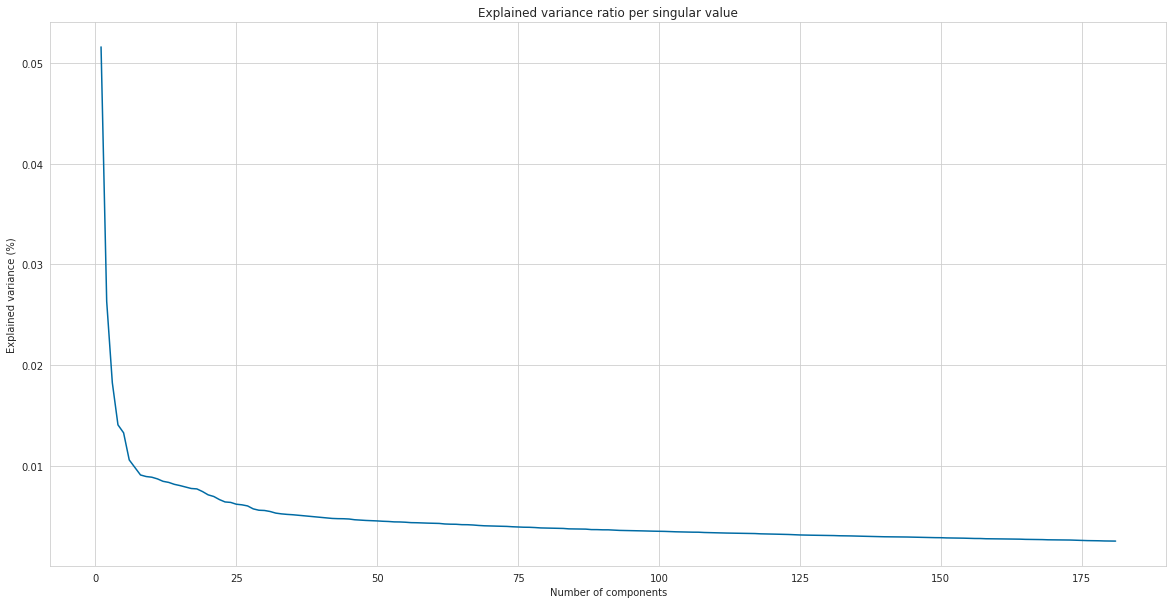

In [109]:
# Make the scree plot
plt.plot(range(1, components + 1), mypca.explained_variance_ratio_ )
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.title('Explained variance ratio per singular value')
plt.savefig('ExplainedVarRatio.pdf') 

Text(0, 0.5, 'Explained variance (%)')

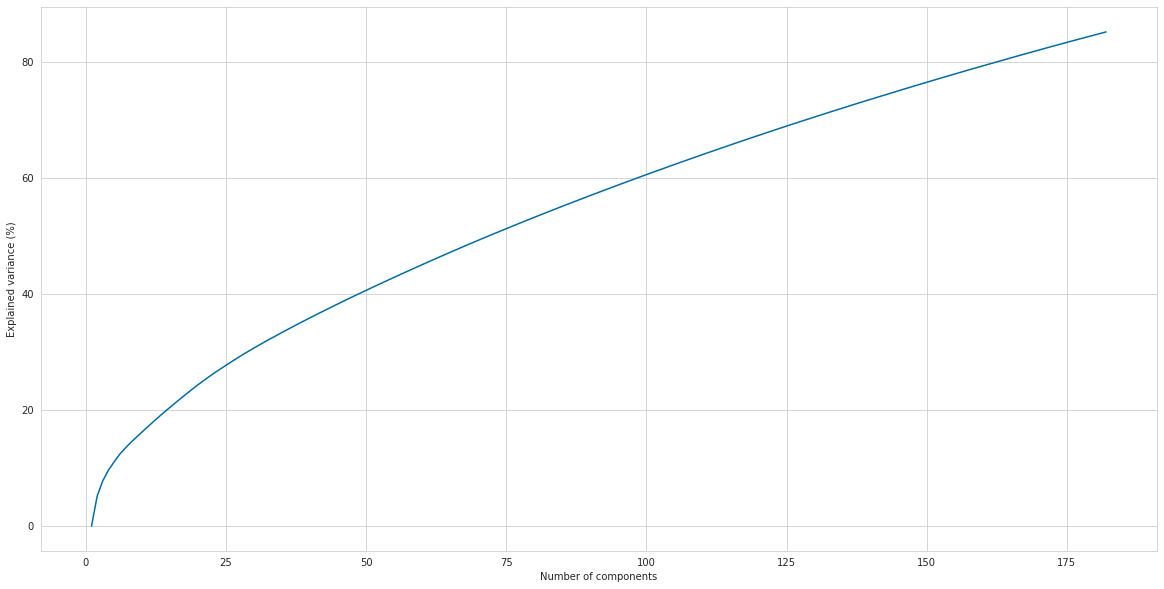

In [110]:
# Make the scree plot
y_h=np.cumsum(mypca.explained_variance_ratio_ * 100)
y_h = np.insert(y_h,0, 0)
plt.plot(range(1, components + 2), y_h)
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

In [111]:
## diagramme de pareto permet de s'assurer que les composantes retenues retiendront bien la majorité de la variabilité.
def pareto(data) :
    from matplotlib.ticker import PercentFormatter
    y = list(data)
    x = range(len(data))
    ycum = np.cumsum(y)/sum(y)*100
    fig, ax = plt.subplots()
    ax.bar(x,y,color="c")
    ax2 = ax.twinx()
    ax2.plot(x,ycum, color="C1", marker="D", ms=7)
    ax2.axhline(y=80,color="r")
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.ylim(0,110)
    plt.show()

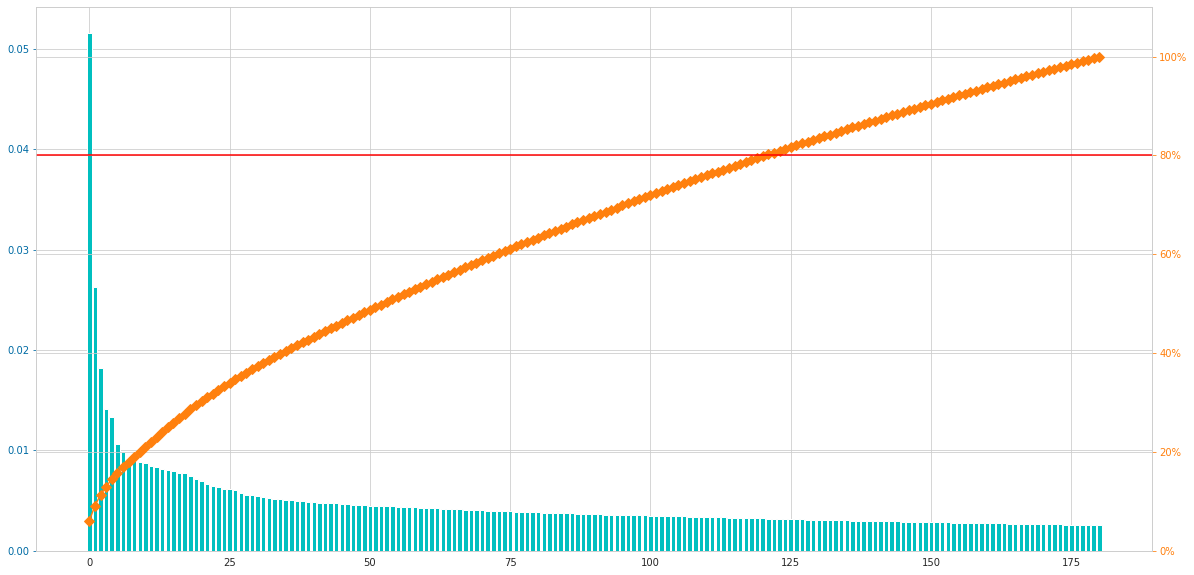

In [112]:
pareto(mypca.explained_variance_ratio_)

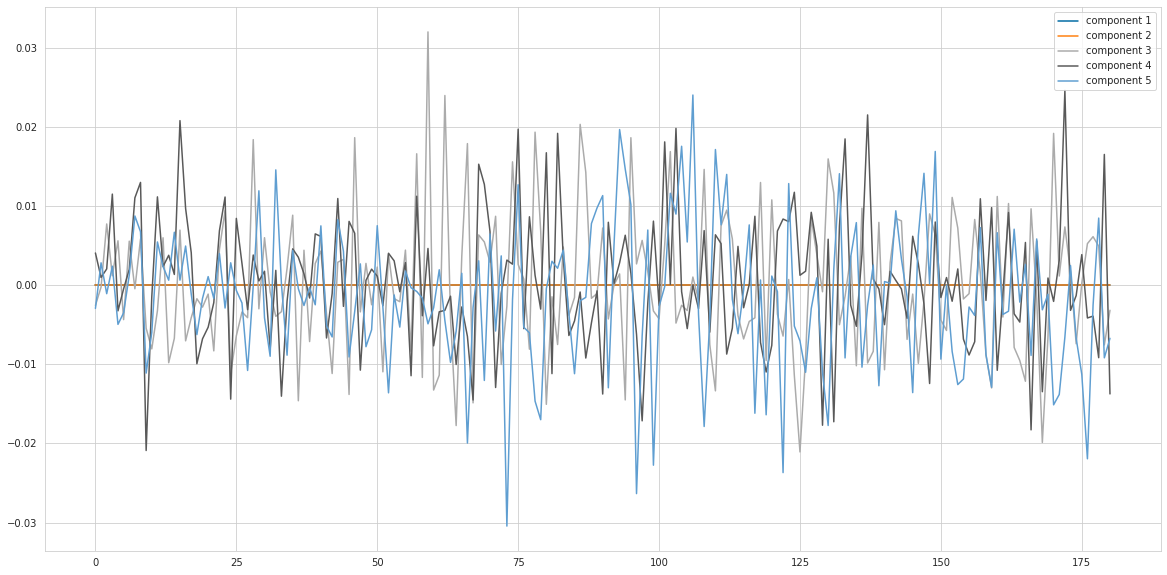

In [113]:
k=0
for comp in mypca.components_.T[:5,:]:
    k+=1
    plt.plot(comp, label=f'component {k}')
plt.legend()

In [114]:
Composantes_principales=mypca.fit_transform(table)
Composantes_principales
columns=['PC'+str(i) for i in range(177)]
nouv_y=pd.DataFrame(data=Composantes_principales,columns=columns)

In [115]:
nouv_y

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC167,PC168,PC169,PC170,PC171,PC172,PC173,PC174,PC175,PC176
0,-6.959692,-7.277235,1.395690,-3.265339,0.046313,4.608479,2.096196,-6.776117,3.988538,-0.952833,...,-1.288896,-3.829815,9.231991,5.078514,-0.577864,3.641721,-2.702521,-3.077106,0.693300,4.167953
1,-12.694225,-5.801567,2.253461,1.012600,-1.809794,-4.767220,-6.103188,-3.539699,3.078115,0.686323,...,3.605455,2.168528,-0.689745,-1.627030,0.270789,0.424327,-0.353942,0.638650,-1.683089,0.561430
2,-9.806552,-2.240221,-5.173526,-2.213474,5.018908,0.831405,-5.418908,-1.822320,1.264171,-3.781296,...,1.751398,-2.251807,-3.777075,2.210052,2.079549,-1.359304,-0.520064,-0.986500,1.466069,0.227994
3,-10.838236,-7.222314,-5.614429,-4.164440,0.452482,7.490616,-1.706826,-3.455419,-0.006483,-1.301173,...,-3.406937,0.671462,1.797331,1.221939,0.084982,0.202269,2.287226,3.244589,0.748447,-1.771775
4,-13.255172,-5.121210,-2.291525,-0.940503,-2.457089,0.429193,-5.952572,-3.256749,1.295544,-1.995084,...,1.598238,-0.205738,-2.107280,-0.011461,3.496506,-0.981706,2.343857,-3.929966,-1.381041,-0.741280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,27.144810,-15.306535,27.272051,21.538098,40.706633,11.165247,2.327413,-3.760287,-2.829459,-8.856503,...,0.081116,-0.514231,2.105194,-1.381014,1.951130,-0.401937,0.666235,0.544763,-1.756992,0.314672
247,15.590384,-13.641837,-5.983083,9.553369,-4.423541,4.094571,-2.680419,-8.053649,-3.380360,1.577387,...,-1.666867,-1.378383,1.631246,-1.303493,2.838779,3.283625,0.429600,0.328866,0.704784,-2.112179
248,11.434627,-8.376810,-5.084044,6.703428,4.954050,0.065275,-6.221700,0.102414,-8.674478,0.051877,...,1.910342,0.512763,-2.079852,0.027619,-1.862627,0.137313,-1.590108,0.599401,0.247095,2.317323
249,10.402851,-12.687076,-8.242591,5.804866,-1.756737,3.677661,-4.061410,1.163671,-9.747347,-0.674095,...,-1.561129,0.379366,-2.359345,1.947537,-1.058553,0.162838,-0.356927,1.087712,0.838433,0.148591


In [116]:
nouv_y.shape

(251, 177)

### Data Pre-processing for Machine Learning

In [117]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
X= pd.concat([
    df['date'].dt.day,
    #df['date'].dt.month,
    df['date'].dt.weekday,
    df['date'].dt.weekofyear,
    #df['product_id'],
    #df['store_id']
],axis=1).drop_duplicates()
X.columns=['day','weekday','weekofyear']#,'product_id','store_id']

#X=pd.get_dummies(X,columns=['product_id','store_id'])
X

,day,weekday,weekofyear
0,1,5,52
1,2,6,52
2,3,0,1
3,4,1,1
4,5,2,1
...,...,...,...
246,4,6,35
247,5,0,36
248,6,1,36
249,7,2,36


Let's to check the correlations: Pearson correlation coefficient.

In [118]:
corr=X.corr()
corr

,day,weekday,weekofyear
day,1.000000,-0.001042,0.003555
weekday,-0.001042,1.000000,0.011673
weekofyear,0.003555,0.011673,1.000000


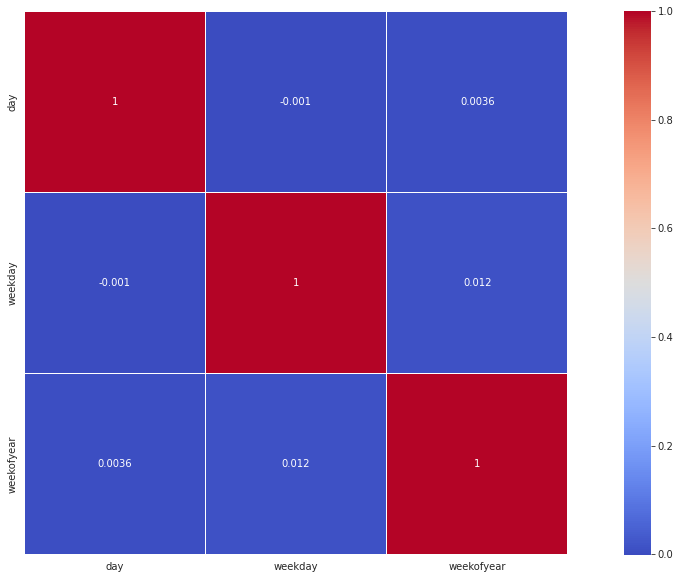

In [119]:
sns.heatmap(corr, square = True, cmap="coolwarm",linewidths=.3,annot=True )

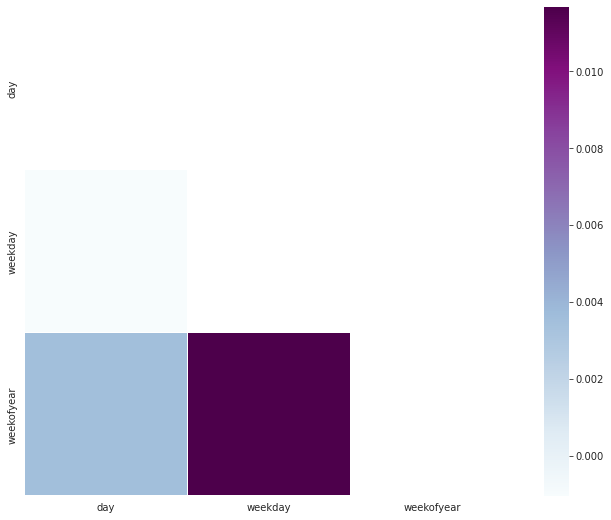

In [120]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

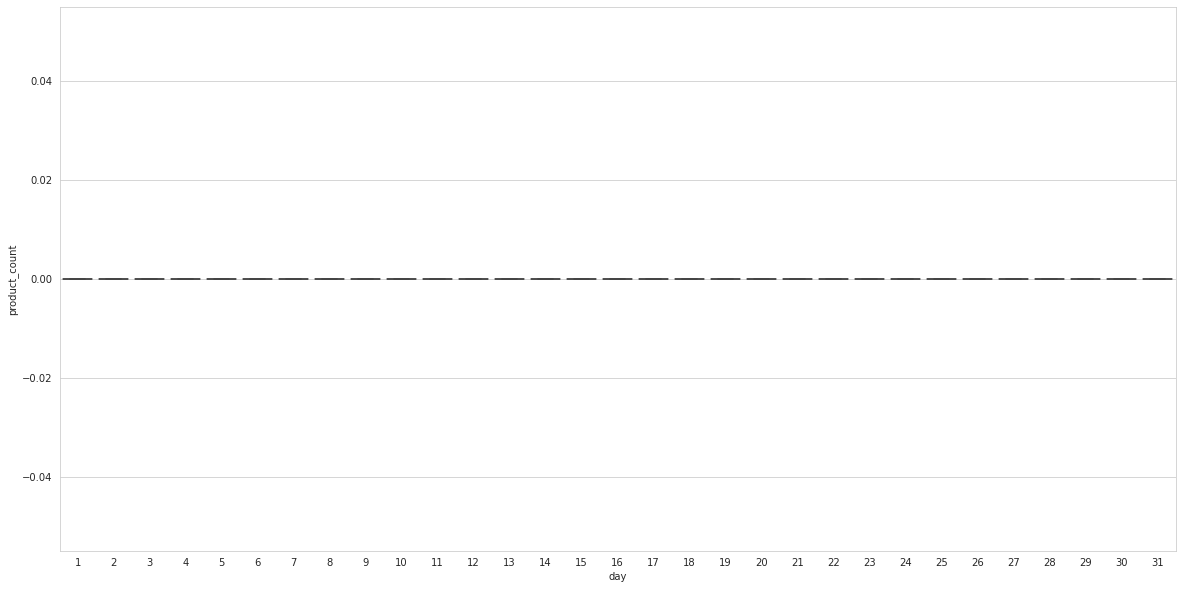

In [121]:
sns.boxplot(X['day'], df['product_count'])
plt.show()

### Splitting the data into Training and Testing sample¶

In [301]:
import math
def normalize(y_train):  
    # Choose between standardization and MinMAx normalization
    scaler=StandardScaler()
    # Storing the fit object for later reference
    scaler=scaler.fit(y_train)
    # Generating the standardized values of X
    yhat=scaler.transform(y_train)
    return yhat, scaler

def split(X,test_size=0.2,n_pca=20):
    n=X.shape[0]
    m=table.shape[0]
    X_train=X[0:math.floor((1-test_size)*n)]
    X_test=X[math.floor((1-test_size)*n):n+1]
    
    y_train=table[0:math.floor((1-test_size)*m)]
    y_test=table[math.floor((1-test_size)*m):m+1]
    
    ## Normalisation 
    yhat, scaler= normalize(y_train)
    ##pca sur les données les sorties d'entrainements.
    mypca=PCA(n_components= n_pca)
    Composantes_principales=mypca.fit_transform(yhat)
    columns=['PC'+str(i) for i in range(n_pca)]
    y_train=pd.DataFrame(data=Composantes_principales,columns=columns)
    
    return X_train,X_test,y_train,y_test,scaler,mypca

def split_temporelMethod(test_size=0.2,n_pca=20):
   m=table.shape[0]
   y_train=table[0:math.floor((1-test_size)*m)]
   y_test=table[math.floor((1-test_size)*m):m+1]
    
   ## Normalisation 
   yhat, scaler= normalize(y_train)
   ##pca sur les données les sorties d'entrainements.
   mypca=PCA(n_components= n_pca)
   Composantes_principales=mypca.fit_transform(yhat)
   columns=['PC'+str(i) for i in range(n_pca)]
   y_train=pd.DataFrame(data=Composantes_principales,columns=columns,index=table[0:math.floor((1-test_size)*m)].index)
    
   return y_train,y_test,scaler,mypca



In [123]:
y_train,y_test,my_scaler,my_pca=split_temporelMethod(test_size=0.2,n_pca=10)

In [124]:
print(y_train.shape)
y_train

(200, 10)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
date,,,,,,,,,,
2022-01-01,-27.398049,33.474483,-21.465253,9.766120,9.658398,-4.376691,19.784970,-15.118825,3.523615,-13.063660
2022-01-02,-27.568981,32.770063,-22.254760,9.956661,6.971386,-3.461870,16.087759,-11.188249,3.188162,-7.132949
2022-01-03,-28.056792,33.426773,-22.973734,9.611119,5.407728,-3.680405,16.138105,-11.036297,4.785296,-3.820747
2022-01-04,-27.368848,32.511821,-20.954127,9.450005,4.628080,-3.756849,14.314535,-8.540223,4.445182,-1.578789
2022-01-05,-26.451483,30.974991,-20.925432,10.200317,5.737522,-4.313615,16.551495,-10.524546,2.781776,-3.035688
...,...,...,...,...,...,...,...,...,...,...
2022-07-15,62.418563,35.662267,17.388537,-5.185044,3.496667,-3.670664,18.478585,18.298157,-12.052114,-1.421930
2022-07-16,63.820676,40.138229,23.112519,9.227047,9.190577,14.440070,4.404949,12.468453,4.529045,-9.815306
2022-07-17,62.311239,46.132903,32.616663,12.252479,53.418005,105.541971,-30.019618,-61.484013,-17.161926,10.902117


In [125]:
sales=y_train.loc[:,['PC'+str(1)]]  #.reset_index() ['date','PC'+str(1)]
sales

,PC1
date,
2022-01-01,33.474483
2022-01-02,32.770063
2022-01-03,33.426773
2022-01-04,32.511821
2022-01-05,30.974991
...,...
2022-07-15,35.662267
2022-07-16,40.138229
2022-07-17,46.132903


### Standardization/Normalization of data

In [126]:
# Choose between standardization and MinMAx normalization
#PredictorScaler=MinMaxScaler()
PredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)

# Generating the standardized values of X
X=PredictorScalerFit.transform(X)


In [127]:
def metrics_(orig,preds):
    MSE=mean_squared_error(y_true=orig,
                   y_pred=preds)
    MAE=mean_absolute_error(y_true=orig,
                   y_pred=preds)
    MSLE=mean_squared_log_error(y_true=np.abs(orig),
                   y_pred=np.abs(preds))
    metrics = dict()
    metrics['MSE']= MSE
    metrics['MAE']= MAE
    metrics['MSLE']= MSLE
    return metrics

#### Brute Force, Linear Regression

In [128]:
test_size=0.2
n=X.shape[0]
m=table.shape[0]
X_train=X[0:math.floor((1-test_size)*n)]
X_test=X[math.floor((1-test_size)*n):n+1]
    
y_train=table[0:math.floor((1-test_size)*m)]
y_test=table[math.floor((1-test_size)*m):m+1]

# Choose between standardization and MinMAx normalization
scaler=StandardScaler()
# Storing the fit object for later reference
scaler=scaler.fit(y_train)
# Generating the standardized values of X
y_train=scaler.transform(y_train)    

In [129]:
# Multiple Linear Regression 
RegModel = LinearRegression()

# Printing all the parameters of Linear regression
print(RegModel)

# Creating the model on Training Data
LREG=RegModel.fit(X_train,y_train)
prediction=LREG.predict(X_test)
preds=scaler.inverse_transform(prediction)
print(LREG.coef_)
# Measuring Goodness of fit in Training data
print('R2 Value or determination coefficient:',metrics.r2_score(y_train, LREG.predict(X_train)))

bf_reg=metrics_(y_test,preds)

LinearRegression()
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.01608648 -0.04941082 -0.01329302]
 ...
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
R2 Value or determination coefficient: 0.21326930829024135


In [130]:
bf_reg

{'MSE': 0.3128708269616411,
 'MAE': 0.28714271984808437,
 'MSLE': 0.08376443431016094}

### Implementation of the prediction model on the selected components
### PCA Inversion (Transform data back to its original space.)

In [131]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [132]:
def metrics_(orig,preds):
    MSE=mean_squared_error(y_true=orig,
                   y_pred=preds)
    MAE=mean_absolute_error(y_true=orig,
                   y_pred=preds)
    MSLE=mean_squared_log_error(y_true=np.abs(orig),
                   y_pred=np.abs(preds))
    metrics = dict()
    metrics['MSE']= MSE
    metrics['MAE']= MAE
    metrics['MSLE']= MSLE
    return metrics

### Simple Average

In [133]:
df=df.sort_values('date')
test_size=0.2
l=math.floor((1-test_size)*df.shape[0])
tab1=df.loc[:l, ['product_id', 'product_count','store_id']].groupby(['product_id','store_id']).mean().reset_index()
tab1

,product_id,store_id,product_count
0,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,0.0
1,5cebfa8d0b259700045dc8aa,5d5d24216115b3000435fa24,0.0
2,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,0.5
3,5cebfa8d0b259700045dc8aa,5f60c3bbf4ff730004b46600,0.5
4,5cebfa8d0b259700045dc8aa,603ceebac776ee00150cfb2d,0.2
...,...,...,...
5413,no product,603f6417954a0c00152089e6,0.0
5414,no product,6051c7cdb7817d00159904fc,0.0
5415,no product,60549b1fd8b3de0015fb392e,0.0
5416,no product,60674dc314734e00150c9fa1,0.0


In [134]:
res = df.loc[l:].merge(tab1, on=['product_id','store_id'], how='right').fillna({'product_count_y':0}).dropna()
res

,store_id,product_id,product_count_x,date,product_count_y
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-02-07,0.0
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-02-08,0.0
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-02-09,0.0
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-02-10,0.0
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,2022-02-11,0.0
...,...,...,...,...,...
858536,60a37a5a0ede6e001545b001,no product,0.0,2022-05-13,0.0
858537,60a37a5a0ede6e001545b001,no product,0.0,2022-05-14,0.0
858538,60a37a5a0ede6e001545b001,no product,0.0,2022-05-15,0.0
858539,60a37a5a0ede6e001545b001,no product,0.0,2022-05-16,0.0


In [135]:
### metrics Simple Average

In [136]:
sa_m=metrics_(res['product_count_x'],res['product_count_y'])
sa_m

{'MSE': 0.6080921458230458,
 'MAE': 0.4622325901195662,
 'MSLE': 0.14595501877394068}

In [137]:
#tab3 =pd.pivot_table(df.loc[l:], values='product_count', index=['product_id','store_id'],
            #columns=['date'], 
            #aggfunc=np.sum)

#tab3.stack().reset_index()

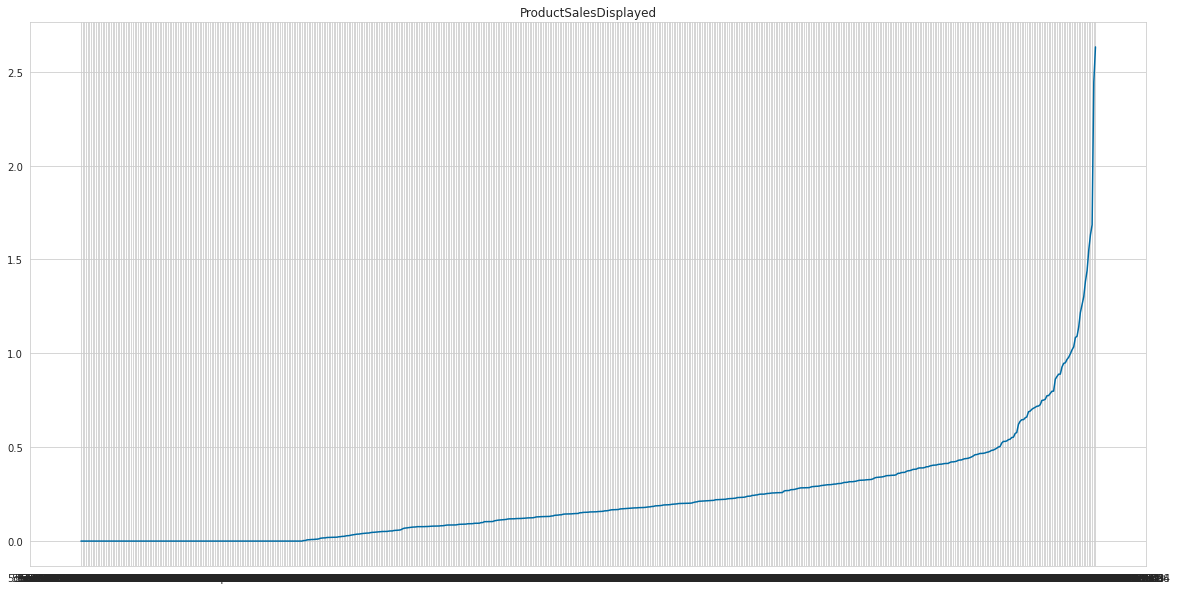

In [138]:
plt.plot(tab.sort_values('product_count')['product_count'])
plt.title('ProductSalesDisplayed')
plt.savefig('ProductSalesDisplayed.pdf') 

#### Normalize Pandas Dataframe With the mean Normalization

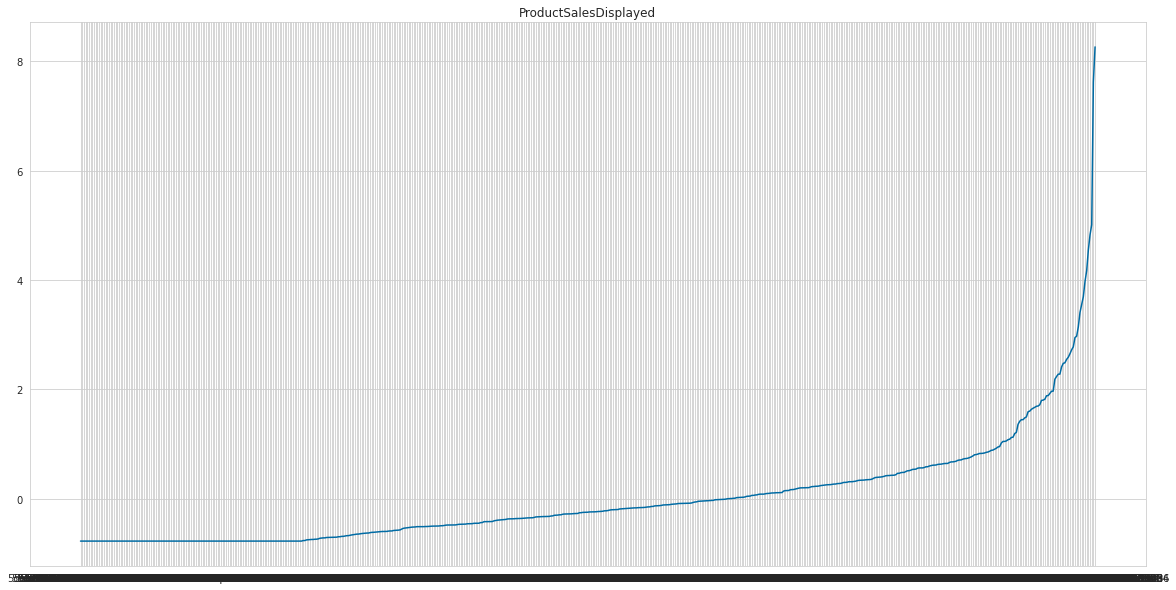

In [139]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

h=pd.DataFrame(tab.sort_values('product_count')['product_count'])

h_mean_norm = mean_norm(h)
plt.plot(h_mean_norm)
plt.title('ProductSalesDisplayed')
plt.savefig('ProductSalesDisplayedNorm.pdf') 


In [140]:
def Accuracy_Score(orig,pred):
    MAPE = np.mean(100 * (np.abs(orig-pred/orig)))
    #print('#'*70,'Accuracy:', 100-MAPE)
    return(100-MAPE)

#### Evaluation of the PCA

In [312]:
df.columns=['store_id', 'product_id', 'product_count', 'date']

In [313]:
def generate_input(df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    input_data = pd.concat([
            df['date'].dt.date,
            df['date'].dt.day,
            # df['date'].dt.month,
            df['date'].dt.weekday,
            df['date'].dt.isocalendar().week.astype('int64'),
        ], axis=1).drop_duplicates()
    input_data.columns = ['date', 'day', 'weekday', 'weekofyear']
    return input_data.reset_index()[['date','day','weekday','weekofyear']].set_index('date')
X= generate_input(df)
X

,day,weekday,weekofyear
date,,,
2022-01-01,1,5,52
2022-01-02,2,6,52
2022-01-03,3,0,1
2022-01-04,4,1,1
2022-01-05,5,2,1
...,...,...,...
2022-09-04,4,6,35
2022-09-05,5,0,36
2022-09-06,6,1,36


In [184]:
def split2(X,test_size=0.2,n_pca=20):
    n=X.shape[0]
    m=table.shape[0]
    X_train=X[0:math.floor((1-test_size)*n)]
    X_test=X[math.floor((1-test_size)*n):n+1]
    
    y_train=table[0:math.floor((1-test_size)*m)]
    y_test=table[math.floor((1-test_size)*m):m+1]
    
    ## Normalisation 
    yhat, scaler= normalize(y_train)
    ##pca sur les données les sorties d'entrainements.
    mypca=PCA(n_components= n_pca)
    Composantes_principales=mypca.fit_transform(yhat)
    columns=['PC'+str(i) for i in range(n_pca)]
    y_train_transform=pd.DataFrame(data=Composantes_principales,columns=columns)
    
    return X_train,X_test,y_train,y_train_transform,y_test,scaler,mypca



In [185]:
def eval_pca(n_pca):
    # split the data and pca over train_set, we learn the transformation matrice
    X_train,X_test,y_train,y_train_transform,y_test,myscaler,mypca=split2(X,test_size=0.2,n_pca=n_pca)
    #transformation over the test_set
       ## Normalisation 
    yhat=myscaler.transform(y_test)
    ## pca over the test set normalized
    principal_components=mypca.transform(yhat)
    # transform test data back to its original space
    Train_preds=myscaler.inverse_transform(mypca.inverse_transform(y_train_transform))
    Test_preds=myscaler.inverse_transform(mypca.inverse_transform(principal_components))
    # calculate the errors
    metrics_hist1=metrics_(y_train,Train_preds)
    metrics_hist2=metrics_(y_test,Test_preds)
    return  metrics_hist1,metrics_hist2 

In [186]:
mon_dico1 ={"Model01":[],"MSE":[],"MAE":[], "MSLE":[]}
mon_dico2 ={"Model02":[],"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [5,10,20,50,100]:
    metriq1,metriq2=eval_pca(n_pca)
    mon_dico1['Model01'].append('perform_pca')
    mon_dico1["MSE"].append(metriq1["MSE"])
    mon_dico1["MAE"].append(metriq1["MAE"])
    mon_dico1["MSLE"].append(metriq1["MSLE"])
    
    mon_dico2['Model02'].append('perform_pca')
    mon_dico2["MSE"].append(metriq2["MSE"])
    mon_dico2["MAE"].append(metriq2["MAE"])
    mon_dico2["MSLE"].append(metriq2["MSLE"])

In [187]:
m01=pd.DataFrame(mon_dico1 ,index = [5,10,20,50,100])
m02=pd.DataFrame(mon_dico2 ,index = [5,10,20,50,100])

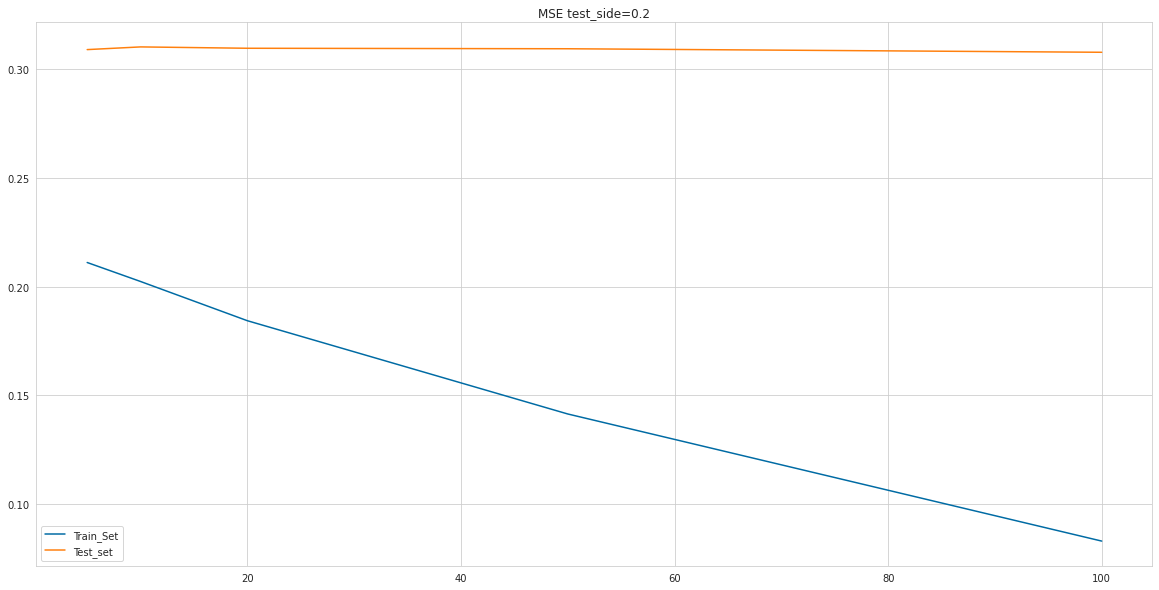

In [188]:
plt.plot(m01.loc[:,'MSE'])
plt.plot(m02.loc[:,'MSE'])
plt.legend(['Train_Set','Test_set'])
plt.title('MSE test_side=0.2')
plt.show()

In [189]:
m02

,Model02,MSE,MAE,MSLE
5,perform_pca,0.309096,0.282548,0.082090
10,perform_pca,0.310338,0.283116,0.082552
20,perform_pca,0.309715,0.283183,0.082605
50,perform_pca,0.309490,0.283325,0.082624
100,perform_pca,0.307868,0.283354,0.082276


#### Multiple Linear Regression

In [190]:

def lin_reg(n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,test_size=0.2,n_pca=n_pca)
    # Multiple Linear Regression 
    RegModel = LinearRegression()

    # Printing all the parameters of Linear regression
    print(RegModel)

    # Creating the model on Training Data
    LREG=RegModel.fit(X_train,y_train)
    prediction=LREG.predict(X_test)
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    # Measuring Goodness of fit in Training data
    print('R2 Valuefor n_pca=: %i' % n_pca ,metrics.r2_score(y_train, LREG.predict(X_train)))


    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,LREG


In [191]:
mon_dico ={"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [5,10,20,50,100]:
    preds,metriq=lin_reg(n_pca)
    mon_dico ["MSE"].append(metriq["MSE"])
    mon_dico ["MAE"].append(metriq["MAE"])
    mon_dico ["MSLE"].append(metriq["MSLE"])
m1=pd.DataFrame(mon_dico ,index = [5,10,20,50,100])
m1

LinearRegression()
R2 Valuefor n_pca=: 5 0.1476849821019764
LinearRegression()
R2 Valuefor n_pca=: 10 0.09033960439570113
LinearRegression()
R2 Valuefor n_pca=: 20 0.06714328529347716
LinearRegression()
R2 Valuefor n_pca=: 50 0.036930518291027455
LinearRegression()
R2 Valuefor n_pca=: 100 0.02243876255205999


,MSE,MAE,MSLE
5,0.310099,0.282536,0.082599
10,0.310473,0.283191,0.082736
20,0.310536,0.283742,0.082853
50,0.310953,0.285117,0.083138
100,0.311987,0.286040,0.083435


In [149]:
#preds,metriq,y_test=lin_reg(20)
# plot what has been learned
#plt.fig(figuresize=(16,10))
#fig = plt.figure(1, figsize=(16, 10))
#plt.plot(y_test.loc[:,('5cebfa8d0b259700045dc8a9', '5d5d24216115b3000435fa24')].to_numpy())
#plt.plot(preds[:,0]) #table.reset_index['date'][:],
#plt.legend(['product_count', 'LRegression_Prediction'])
#plt.show()
#preds.shape

### XGBoost
#### Algorithme de type arbres boostés

In [192]:
Predictors=['day','weekday','weekofyear']
# Xtreme Gradient Boosting (XGBoost) with hyperparameter-tuning-with-grid-search 
def xgb1(n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,test_size=0.2,n_pca=n_pca)
    
    params = {
    'min_child_weight': [4, 8],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(5, 11)], #range(6,11)?
    'colsample_bytree': [i / 10.0 for i in range(5, 11)],
    'max_depth': [3, 4, 5], ##
    'eta': [0.01,0.05, 0.1, 0.15,0.2,0.3,0.5]
    }
    
    # Initialize XGB and GridSearch
    RegModel=XGBRegressor(max_depth=2, 
                          learning_rate=0.1, 
                          n_estimators=1000, 
                          objective='reg:squarederror',
                          booster='gbtree')

    grid = GridSearchCV(RegModel, params,cv=5,verbose=2) # the default 5-fold cross validation or None
    # Creating the model on Training Data 
    grid_results=grid.fit(X_train, y_train)
    
    # Extract the best parameters 
    best_xgb = grid_results.best_estimator_
    
    best_xgb.score(X_test, y_test)
   
    # Printing all the parameters of the XGB
    print(best_xgb)
    
    #and predictions
    prediction=best_xgb.predict(X_test)
    
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    # Measuring Goodness of fit in Training data
    print('R2 Value for n_pca=: %i' % n_pca,metrics.r2_score(y_train,  best_xgb.predict(X_train)))

    # Plotting the feature importance for Top 10 most important columns
    %matplotlib inline
    feature_importances = pd.Series( best_xgb.feature_importances_, index=Predictors)
    feature_importances.nlargest(10).plot(kind='barh')
    
    #Plotting one of the Decision Trees in Random Forest
    # PLotting a single Decision Tree from Random Forest
    #from xgboost import plot_tree
    #fig, ax = plt.subplots(figsize=(20, 8))
    #plot_tree(XGB, num_trees=10, ax=ax)
    
    #from dtreeplt import dtreeplt
    #dtree = dtreeplt(model=  RegModel.estimators_[4], feature_names=Predictors)
    #fig = dtree.view()
    
    metrics_hist=metrics_(y_test,preds)
    return y_test,preds,metrics_hist #, best_xgb

y_,preds,metriq=xgb1(n_pca=20)

plt.plot(y_test.loc[134])

plt.plot(y_test.loc[134],label="actual")
plt.plot(preds[0], label="predicted")

In [298]:
from sklearn.ensemble import GradientBoostingRegressor

In [314]:
def xgb(n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,test_size=0.2,n_pca=n_pca)
    RegModel=GradientBoostingRegressor(max_depth=3, 
                          learning_rate=0.1, 
                          n_estimators=1000, 
                          )

    # Creating the model on Training Data
    XGB=RegModel.fit(X_train,y_train.values)
    prediction=XGB.predict(X_test) 
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    print('R2 Value for n_pca=: %i' % n_pca,metrics.r2_score(y_train, XGB.predict(X_train)))
    
    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,XGB

In [316]:
#!pip install xgboost # Uninstall and install xgboost if error DataFrame for label cannot have multiple columns

n_pca = 5
X_train,X_test,y_train,y_test,myscaler,mypca=split(X,test_size=0.2,n_pca=n_pca)
RegModel=XGBRegressor(max_depth=3, 
                          learning_rate=0.1, 
                          n_estimators=1000, 
                          objective='reg:squarederror',
                          booster='gbtree')

    # Creating the model on Training Data
XGB=RegModel.fit(X_train,y_train.values)
prediction=XGB.predict(X_test)
preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
print('R2 Value for n_pca=: %i' % n_pca,metrics.r2_score(y_train, XGB.predict(X_train)))
    
metrics_hist=metrics_(y_test,preds)
metrics_hist

ValueError: ignored

In [227]:
RegModel.predict(X_test).shape

(51,)

In [ ]:
X_train.dtypes

In [306]:
mon_dico ={"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [5,10,20,50,100]:
    preds,metriq=xgb(n_pca)
    mon_dico ["MSE"].append(metriq["MSE"])
    mon_dico ["MAE"].append(metriq["MAE"])
    mon_dico ["MSLE"].append(metriq["MSLE"])
m2=pd.DataFrame(mon_dico ,index = [5,10,20,50,100])
m2

TypeError: ignored

#### Random Forest
##### Algorithme de type Bagging 
##### hyperparameter-tuning with GridSearch

In [229]:
# Random Forest (Bagging of multiple Decision Trees)  with GridSearch
def RandForest(n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,test_size=0.2,n_pca=n_pca)
    
    # Define Parameters
    max_depth=[2, 8, 16]
    n_estimators = [64, 100, 128]
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

    # Build the grid search
    dfrst = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
    
    # Creating the model on Training Data
    grid_results = grid.fit(X_train, y_train)
    
    # Extract the best decision forest 
    best_clf = grid_results.best_estimator_
   
    # Printing all the parameters of Random Forest
    print(best_clf)

    prediction=best_clf.predict(X_test)
    
    ##inversion de pca et de la normalisation
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))

    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    print('R2 Value for train_set and n_pca=: %i' % n_pca,metrics.r2_score(y_train,  best_clf.predict(X_train)))
    print('R2 Value for test_set and n_pca=: %i' % n_pca,metrics.r2_score(y_test, preds))
    
    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,  best_clf

In [230]:
preds,metriq=RandForest(n_pca=20)

RandomForestRegressor(max_depth=16, n_estimators=128)
R2 Value for train_set and n_pca=: 20 0.8483611417132316
R2 Value for test_set and n_pca=: 20 -4.487228713089149e+29


In [231]:
metriq

{'MSE': 0.36249728404082326,
 'MAE': 0.287471538568563,
 'MSLE': 0.09514670619299771}

In [232]:

mon_dico ={"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [5,10,20,50,100]:
    preds,metriq=RandForest(n_pca)
    mon_dico ["MSE"].append(metriq["MSE"])
    mon_dico ["MAE"].append(metriq["MAE"])
    mon_dico ["MSLE"].append(metriq["MSLE"])
m3=pd.DataFrame(mon_dico ,index = [5,10,20,50,100])
m3

RandomForestRegressor(max_depth=16, n_estimators=128)
R2 Value for train_set and n_pca=: 5 0.9631009281849984
R2 Value for test_set and n_pca=: 5 -4.1390356101610395e+29
RandomForestRegressor(max_depth=8)
R2 Value for train_set and n_pca=: 10 0.9059939797117673
R2 Value for test_set and n_pca=: 10 -4.024003470238619e+29
RandomForestRegressor(max_depth=8, n_estimators=128)
R2 Value for train_set and n_pca=: 20 0.8469725510875493
R2 Value for test_set and n_pca=: 20 -5.349700201354266e+29
RandomForestRegressor(max_depth=8)
R2 Value for train_set and n_pca=: 50 0.7524400805403343
R2 Value for test_set and n_pca=: 50 -9.038531577875603e+29
RandomForestRegressor(max_depth=8, n_estimators=128)
R2 Value for train_set and n_pca=: 100 0.6613870551616736
R2 Value for test_set and n_pca=: 100 -1.2407388620178327e+30


,MSE,MAE,MSLE
5,0.353864,0.287974,0.091448
10,0.360620,0.285678,0.093655
20,0.354470,0.288212,0.093732
50,0.364710,0.287438,0.096252
100,0.360259,0.285016,0.095397


### MultiOutput Regressor sklearn
#### with svm

In [233]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR

In [234]:
# Support Vector Machines(SVM)
def Multi_svm(n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,test_size=0.2,n_pca=n_pca)
    
    svregressor= svm.SVR(C=50, kernel='rbf', gamma=0.01) # LinearSVR() #
    
    mulregressor = MultiOutputRegressor(svregressor)
    # Printing all the parameters
    print(mulregressor)

    # Creating the model on Training Data
    SVM=mulregressor.fit(X_train,y_train)
    prediction=SVM.predict(X_test)
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    print('R2 Value for n_pca=: %i' % n_pca,metrics.r2_score(y_train, SVM.predict(X_train)))
    
    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,SVM

In [235]:
mon_dico ={"Model4":[],"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [5,10,20,50,100]:
    preds,metriq=lin_reg(n_pca)
    mon_dico['Model4'].append('PCA-Multi_svm')
    mon_dico["MSE"].append(metriq["MSE"])
    mon_dico["MAE"].append(metriq["MAE"])
    mon_dico["MSLE"].append(metriq["MSLE"])
m4=pd.DataFrame(mon_dico ,index = [5,10,20,50,100])
m4

LinearRegression()
R2 Valuefor n_pca=: 5 0.14691212807370782
LinearRegression()
R2 Valuefor n_pca=: 10 0.0868837338914167
LinearRegression()
R2 Valuefor n_pca=: 20 0.06328283640516981
LinearRegression()
R2 Valuefor n_pca=: 50 0.036198787960438315
LinearRegression()
R2 Valuefor n_pca=: 100 0.023129882384124122


,Model4,MSE,MAE,MSLE
5,PCA-Multi_svm,0.310113,0.282533,0.082597
10,PCA-Multi_svm,0.310557,0.283113,0.082713
20,PCA-Multi_svm,0.310387,0.283600,0.082833
50,PCA-Multi_svm,0.311298,0.285062,0.083226
100,PCA-Multi_svm,0.312114,0.286198,0.083485


#### Mobile Average

In [236]:
rolling_mean=table.rolling(window=14,axis=1).mean().shift(1)
rolling_std=table.rolling(window=14, axis=1).std().shift(1)


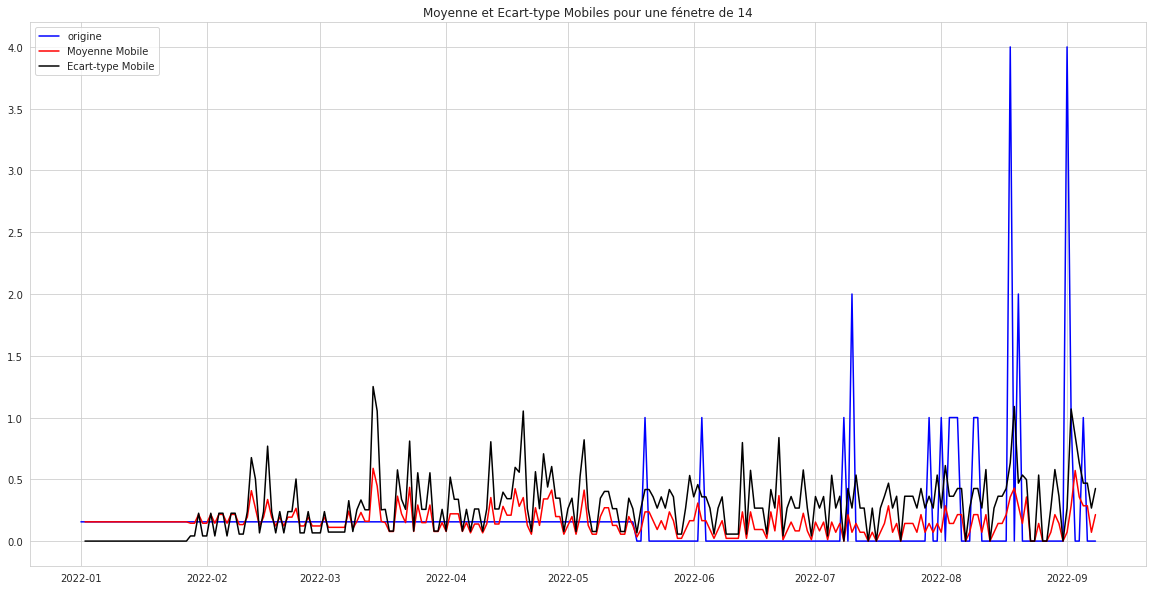

In [237]:
k=34
plt.plot(table.iloc[:,k], color='blue', label='origine')
plt.plot(rolling_mean.iloc[:,k], color='red', label='Moyenne Mobile')
plt.plot(rolling_std.iloc[:,k], color='black', label='Ecart-type Mobile')
plt.legend(loc='best')
plt.title('Moyenne et Ecart-type Mobiles pour une fénetre de 14')
plt.show()

In [238]:
err_rolling=metrics_(rolling_mean.fillna(0),table)
metrics_MA=pd.DataFrame([err_rolling])
metrics_MA['Model5']='Rolling or MA'
#metrics_MA.set_index('Model', inplace = True)
metrics_MA

,MSE,MAE,MSLE,Model5
0,0.318329,0.278234,0.08459,Rolling or MA


In [239]:
table.iloc[:,34]

date
2022-01-01    0.155846
2022-01-02    0.155846
2022-01-03    0.155846
2022-01-04    0.155846
2022-01-05    0.155846
                ...   
2022-09-04    0.000000
2022-09-05    1.000000
2022-09-06    0.000000
2022-09-07    0.000000
2022-09-08    0.000000
Name: (5cebfa8d0b259700045dc8aa, 627e47501f5ac0001658172d), Length: 251, dtype: float64

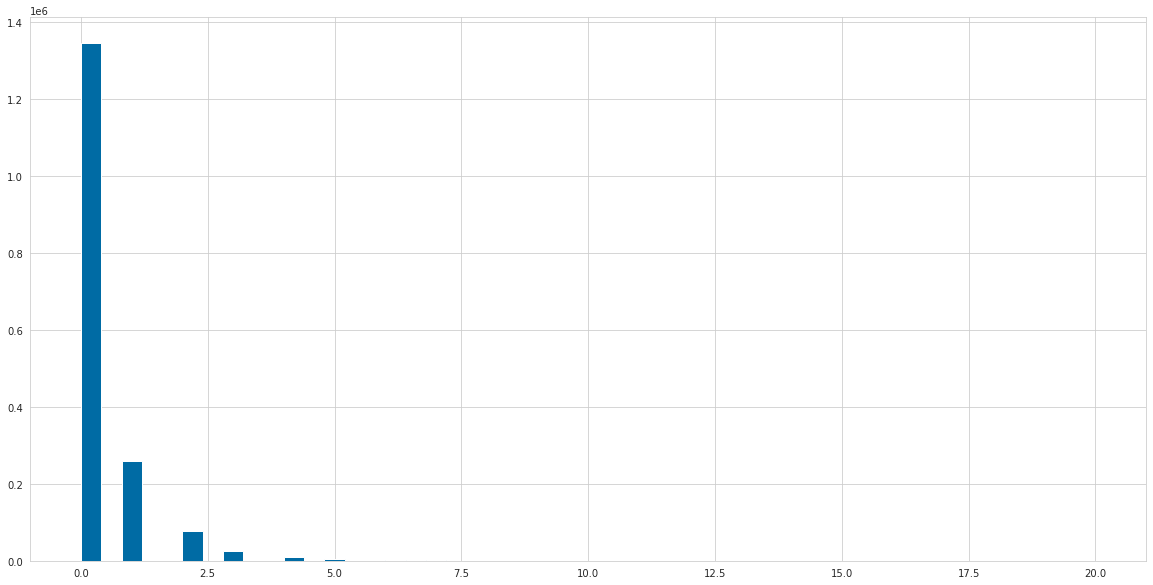

In [240]:
series3['product_count'].hist(bins=50)

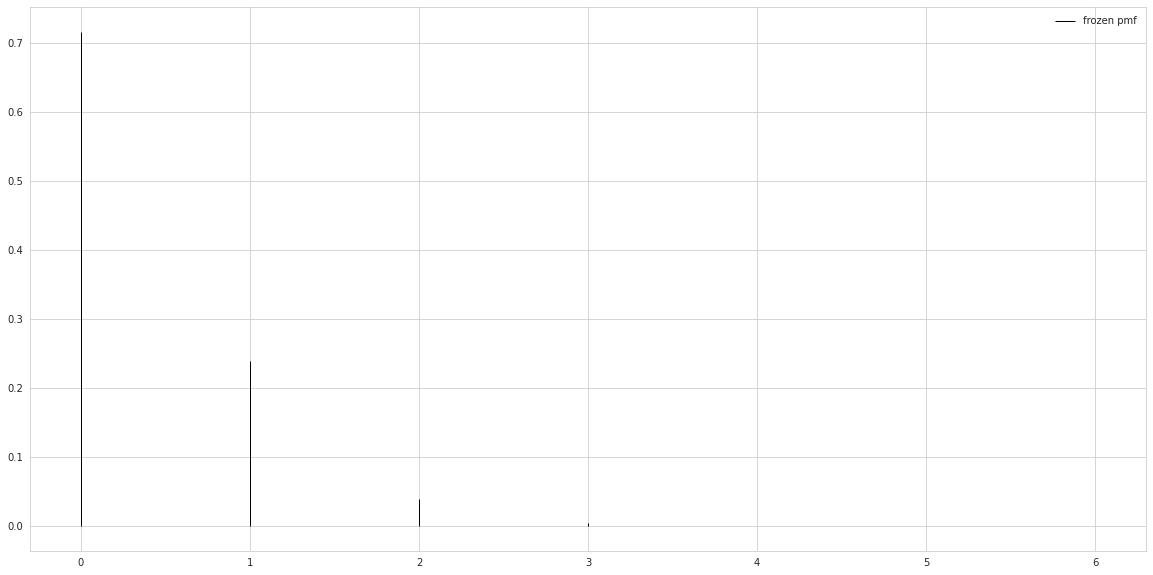

In [241]:
mu = series3['product_count'].mean()
from scipy.stats import poisson
fig, ax = plt.subplots(1, 1)
rv = poisson(mu)
x=np.arange(poisson.ppf(0.01, mu),             poisson.ppf(0.99999999, mu))
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,      label='frozen pmf') 
ax.legend(loc='best', frameon=False)
plt.show()

### Sum Up

In [242]:
sa_m=pd.DataFrame([sa_m])
sa_m['Model']='Simple_Average'
sa_m.set_index('Model', inplace = True)

In [243]:
bf_reg=pd.DataFrame([bf_reg])
bf_reg['Model4']='ID-BruteForceRegressor'
bf_reg.set_index('Model4', inplace = True)

In [245]:
m1['Model1']='PCA-Lin_Reg'
m2['Model2']='PCA-XGB'
m3['Model3']='PCA-Rand_Foret'


### Others Models/Algorithms

#### LSTM-ANN

#### Prophet

In [247]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 134 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.7 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638785 sha256=e60d5b436570a9341417a9cb4ca9c087a87748cb477ecd918f51ba4db85e44d2
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the 

In [248]:
# importing Prophet model
# importing prophet library
import fbprophet
from fbprophet import Prophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [249]:
# FaceBook Model Prophet()
def prophet(n_pca):
    y_train,y_test,myscaler,mypca=split_temporelMethod(test_size=0.2,n_pca=n_pca)
    y_preds=pd.DataFrame(table.index)
    for i in range (n_pca):
      # set the uncertainty interval to 95% (the Prophet default is 80%)
      my_model = Prophet(interval_width = 0.95)
      sales=y_train.loc[:,['PC'+str(i)]]
      sales=sales.reset_index()
      sales = sales.rename(columns = {'date': 'ds',
                                'PC'+str(i): 'y'})

      # Creating the model on Training Data
      my_model.fit(sales)

      # dataframe that extends into future 5 weeks
      future_dates = my_model.make_future_dataframe(periods=len(y_test), freq='D')
      # predictions 
      forecast = my_model.predict(future_dates) #the forecast is over the whole training set + the test set
      y_preds['Forecast'+str(i)]=forecast.yhat.values


    prediction=y_preds.set_index('date')
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Testing data 'MSE: %.3f' % MSE
    metrics_hist=metrics_(y_test,preds[-len(y_test):])

    preds_Total=pd.DataFrame(preds,index=table.index)    
    return preds_Total,metrics_hist #,my_model

In [250]:
mon_dico ={"Model6":[],"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [5,10]:
    preds,metriq=prophet(n_pca)
    if(n_pca==5):
      preds_Total=preds
    mon_dico['Model6'].append('Prophet')
    mon_dico["MSE"].append(metriq["MSE"])
    mon_dico["MAE"].append(metriq["MAE"])
    mon_dico["MSLE"].append(metriq["MSLE"])
m6=pd.DataFrame(mon_dico ,index = [5,10])
m6


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,Model6,MSE,MAE,MSLE
5,Prophet,0.377400,0.317105,0.097683
10,Prophet,0.374993,0.315030,0.097082


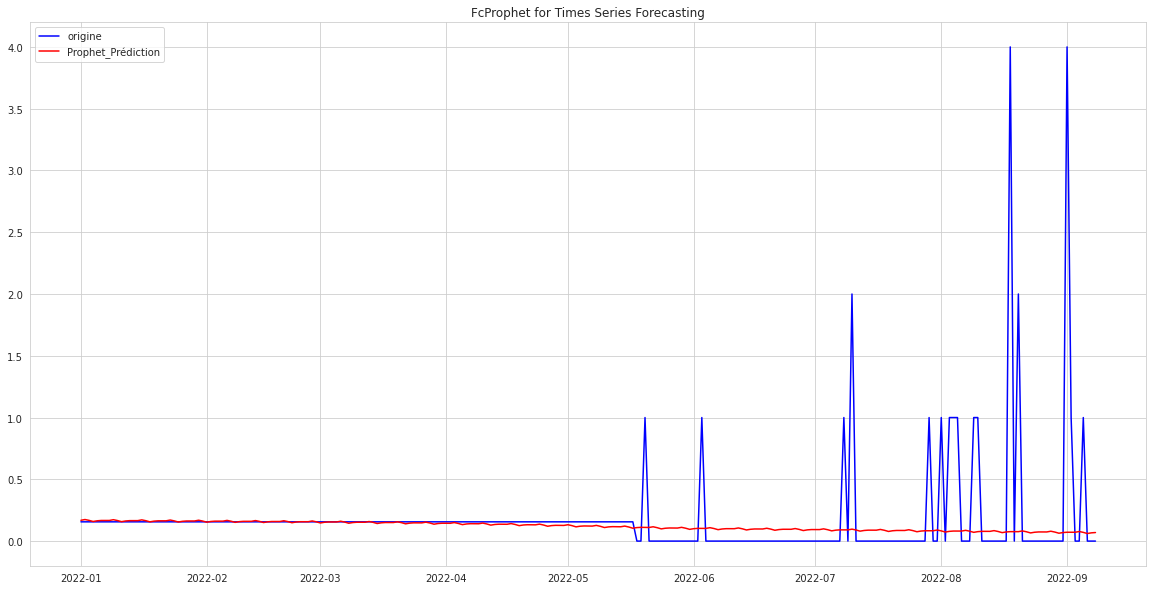

In [251]:
k=34
plt.plot(table.iloc[:,k], color='blue', label='origine')
plt.plot(preds_Total.iloc[:,k], color='red', label='Prophet_Prédiction')
plt.legend(loc='best')
plt.title('FcProphet for Times Series Forecasting')
plt.savefig('ProphetPlot_.pdf')
plt.show()

#### SimpleExpSmoothing

In [252]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [259]:
# Simple Exponential Smothing Model
def SimExpSmoothing(n_pca):
  y_preds=pd.DataFrame(table.loc[datetime.date(2022,8,7):].index)
  ## Normalisation 
  yhat, myscaler= normalize(table)
  ##pca sur les données les sorties d'entrainements.
  mypca=PCA(n_components= n_pca)
  Composantes_principales=mypca.fit_transform(yhat)
  columns=['PC'+str(i) for i in range(n_pca)]
  data=pd.DataFrame(data=Composantes_principales,columns=columns,index=table.index)
  
  #train the model over each principal component
  for i in range (n_pca): 
    sales=data.loc[:,['PC'+str(i)]]
    # Creating the model on Training Data
    fit=SimpleExpSmoothing(sales).fit(smoothing_level=0.6, optimized=False)   #initialization_method='heuristic'
    fcast = fit.forecast(7).rename(r"$\alpha=0.6$")

    #fit = SimpleExpSmoothing(sales).fit() #, initialization_method="estimated").fit()
    #fcast = fit.forecast(5).rename(r"$\alpha=%s$" % fit.model.params["smoothing_level"])
    
    
    if(i==0):
      Predict=pd.DataFrame(table.index,columns=['date']) 
      bestfcast=pd.DataFrame(fcast.index,columns=['date'])
    bestfcast['PC'+str(i)]=fcast.values
    Predict['PC'+str(i)]=fit.fittedvalues.values

    
    # predictions 
    start_date= datetime.date(2022,8,7) 
    end_date= datetime.date(2022,9,8)  #y_test.index[len(y_test)-1]  
      
    yhat2=fit.predict(start=start_date, end=end_date)
    y_preds['Forecast'+str(i)]=yhat2.values
 
  prediction=y_preds.set_index('date')
  preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
  preds=pd.DataFrame(preds,index=prediction.index) 
  # Measuring Goodness of fit in Testing data 'MSE: %.3f' % MSE
  metrics_hist=metrics_(table.loc[datetime.date(2022,8,7):],preds)

  Predict=Predict.set_index('date')
  Predict=pd.DataFrame(myscaler.inverse_transform(mypca.inverse_transform(Predict)),index=table.index)
  bestfcast=bestfcast.set_index('date')
  bestfcast=pd.DataFrame(myscaler.inverse_transform(mypca.inverse_transform(bestfcast)),index=fcast.index)
    
  return Predict, bestfcast,metrics_hist,fcast.name


In [260]:
print(datetime.datetime(2022,8,7))

2022-08-07 00:00:00


In [261]:
mon_dico ={"Model7":[],"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [10,5]:
    Predict, bestfcast,metriq,fcast=SimExpSmoothing(n_pca)
    mon_dico['Model7'].append('SimExpSmoothing')
    mon_dico["MSE"].append(metriq["MSE"])
    mon_dico["MAE"].append(metriq["MAE"])
    mon_dico["MSLE"].append(metriq["MSLE"])
m7=pd.DataFrame(mon_dico ,index = [10,5])
m7=m7.iloc[[1,0]] #inverser les lignes
m7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

,Model7,MSE,MAE,MSLE
5,SimExpSmoothing,0.277753,0.254890,0.072571
10,SimExpSmoothing,0.286380,0.255994,0.075070


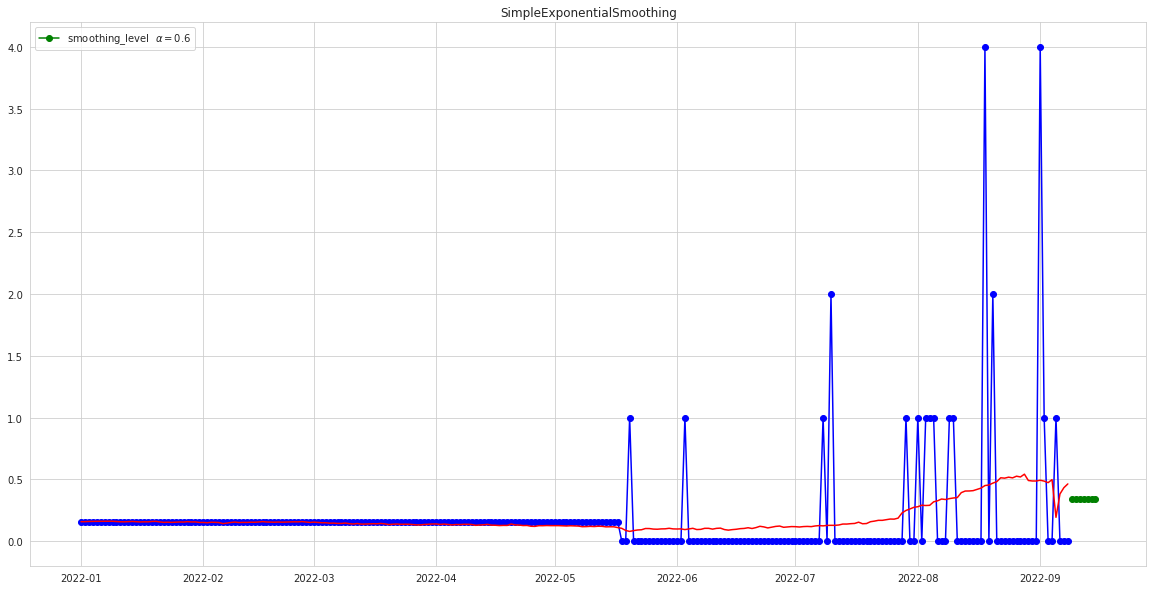

In [262]:
k=34
plt.figure(figsize=(20, 10))
plt.plot(table.iloc[:,k], marker="o",color="blue")
plt.plot(Predict.iloc[:,k], color="red")

(line1,) = plt.plot(bestfcast.iloc[:,k], marker="o",color="green")
plt.legend([line1], ['smoothing_level  '+ fcast])
plt.title('SimpleExponentialSmoothing')
plt.savefig('SimpleExpSmoothingPlot.pdf')

#### Sarima

### DeepAR_Amazon

In [295]:
# constants
start_train_date = pd.to_datetime(datetime(2022,1,1), format='%Y-%m-%d') 
end_train_date = pd.to_datetime(datetime(2022,9,8), format='%Y-%m-%d')

data_freq='D' 
nb_days_pred = 51 #14

# Possibility to set learning rate and its decay factor
# For now we set them to default values from https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html
lr_decay_factor = 0.5
learning_rate = 0.001
# For the nb of epochs, default is 100 but we set it to less to reduce training time.
# We will train with 100 epochs in the stability study, see variable DEEPAR_MAX_EPOCH_LIST_STR below.
max_epochs = 30
num_eval_samples=100

In [269]:
#!pip3 install mxnet
#!pip install gluonts

In [270]:
import gluonts
from gluonts.model.deepar import DeepAREstimator
#from gluonts.trainer import Trainer
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm 
from datetime import datetime

In [296]:
def DeepAR_Amazon(X,y,n_pca,feat_dynamic_cols = None):
    components = ['PC' + str(i) for i in range(n_pca)]
    X_train, X_test, y_train, y_test, myscaler, mypca = split(X, y, test_size=0.2, n_pca=n_pca)
    y_train['time'] = X_train['time']
    y_train = y_train.set_index('time')
    # data for evaluation prediction
    Composantes_principales = mypca.transform(y_test)
    columns = ['PC' + str(i) for i in range(n_pca)]
    testy = pd.DataFrame(data=Composantes_principales, columns=columns)
    testy['time'] = X_test['time'].values
    testy = testy.set_index('time')

    estimator = DeepAREstimator(freq=data_freq,
                                prediction_length=nb_days_pred,
                                trainer=Trainer(epochs=max_epochs, learning_rate=learning_rate,
                                                learning_rate_decay_factor=lr_decay_factor),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    # estimator.set_hyperparameters(**hyperparameters)
    # the DeepAR model determines the input in the dict (.json, .json.gz, or .parquet) format
    if feat_dynamic_cols is not None:

        training_data = ListDataset(
            [{"item_id": component,
              "start": str(start_train_date),
              "target": y_train[component][:end_train_date],
              "feat_dynamic_real": [X_train[feat_dynamic_col]   #[:end_train_date]
                                    for feat_dynamic_col in feat_dynamic_cols]
              }
             for component in components],
            freq=data_freq
        )
        test_data = ListDataset(
            [{"item_id": component,
              "start": str(end_train_date),
              "target": testy[component],  # [:test_date + timedelta(hours=nb_days_pred)],
              "feat_dynamic_real": [
                  X_test[feat_dynamic_col]  # [:test_date + timedelta(hours=nb_days_pred)]
                  for feat_dynamic_col in feat_dynamic_cols]
              }
             for component in components],
            freq=data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": component,
              "start": str(start_train_date),
              "target": y_train[component][:end_train_date]
              }
             for component in components],
            freq=data_freq
        )
        test_data = ListDataset(
            [{"item_id": component,
              "start": str(end_train_date),
              "target": testy[component],  # [:test_date + timedelta(hours=nb_days_pred)],
              }
             for component in components],
            freq=data_freq
        )

    predictor = estimator.train(training_data=training_data)
    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=num_eval_samples)

    forecasts = list(tqdm(forecast_it, total=len(testy)))
    tss = list(tqdm(ts_it, total=len(testy)))

    results_mean = {}
    for i in range(n_pca):
        forecast = forecasts[i]
        results_mean[forecast.item_id] = forecast.mean
    prediction = pd.DataFrame(results_mean, index=testy.index)
    preds = myscaler.inverse_transform(mypca.inverse_transform(prediction))
    # Measuring Goodness of fit in Testing data 'MSE: %.3f' % MSE
    metrics_hist = metrics_(y_test, preds)

    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    coef_determ = 'null'  # metrics.r2_score(y_train, preds[:len(y_test)])
    metrics_hist['R2'] = coef_determ
    preds_Total=pd.DataFrame(preds,index=y_test.index)    
    return preds_Total,metrics_hist

In [290]:
def generate_input(df: pd.DataFrame) -> pd.DataFrame:
    df['time'] = pd.to_datetime(df.time, format='%Y-%m-%d')
    input_data = pd.concat([
            df['time'].dt.date,
            df['time'].dt.day,
            # df['time'].dt.month,
            df['time'].dt.weekday,
            df['time'].dt.isocalendar().week,
        ], axis=1).drop_duplicates()
    input_data.columns = ['time', 'day', 'weekday', 'weekofyear']
    return input_data.reset_index()[['time','day','weekday','weekofyear']]
df.columns=['store_id', 'product_id','product_count',	'time']
X=generate_input(df)
X

,time,day,weekday,weekofyear
0,2022-01-01,1,5,52
1,2022-01-02,2,6,52
2,2022-01-03,3,0,1
3,2022-01-04,4,1,1
4,2022-01-05,5,2,1
...,...,...,...,...
246,2022-09-04,4,6,35
247,2022-09-05,5,0,36
248,2022-09-06,6,1,36
249,2022-09-07,7,2,36


In [291]:
#table=timestep_product_store
import math
def normalize(y_train):  
    # Choose between standardization and MinMAx normalization
    scaler=StandardScaler()
    # Storing the fit object for later reference
    scaler=scaler.fit(y_train)
    # Generating the standardized values of X
    yhat=scaler.transform(y_train)
    return yhat, scaler

def split(X,y,test_size=0.2,n_pca=20):
    n=X.shape[0]
    m=y.shape[0]
    X_train=X[0:math.floor((1-test_size)*n)]
    X_test=X[math.floor((1-test_size)*n):n+1]
    
    y_train=y[0:math.floor((1-test_size)*m)]
    y_test=y[math.floor((1-test_size)*m):m+1]
    
    ## Normalisation 
    yhat, scaler= normalize(y_train)
    ##pca sur les données les sorties d'entrainements.
    mypca=PCA(n_components= n_pca)
    Composantes_principales=mypca.fit_transform(yhat)
    columns=['PC'+str(i) for i in range(n_pca)]
    y_train=pd.DataFrame(data=Composantes_principales,columns=columns)
    
    return X_train,X_test,y_train,y_test,scaler,mypca

In [297]:
y=table
mon_dico ={"Model8":[],"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [10,5]:
    Predict,metriq =DeepAR_Amazon(X,y,n_pca,feat_dynamic_cols = None) 
    mon_dico['Model8'].append('DeepAR')
    mon_dico["MSE"].append(metriq["MSE"])
    mon_dico["MAE"].append(metriq["MAE"])
    mon_dico["MSLE"].append(metriq["MSLE"])
m8=pd.DataFrame(mon_dico ,index = [10,5])
m8=m8.iloc[[1,0]] #inverser les lignes
m8

100%|██████████| 50/50 [00:07<00:00,  6.97it/s, epoch=30/30, avg_epoch_loss=1.58]


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  6.70it/s, epoch=30/30, avg_epoch_loss=1.37]


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

,Model8,MSE,MAE,MSLE
5,DeepAR,0.311518,0.287551,0.081275
10,DeepAR,0.311518,0.287551,0.081275


#### Summary PCA

In [317]:
frames=(m02,bf_reg,metrics_MA,m1,m4,m3, m8,m6,m7,sa_m)
m= pd.concat(frames).reset_index()
m['Model'] = m['Model1'].fillna(m['Model02']).fillna(m['Model8']).fillna(m['Model3']).fillna(m['Model4']).fillna(m['Model5']).fillna(m['Model6']).fillna(m['Model7']).fillna(m['index'])
m = m.set_index(['Model','index']).drop(['Model02','Model1','Model8','Model3','Model4','Model5','Model6','Model7'],axis=1)
m

MSE       MAE      MSLE
Model                  index                                               
perform_pca            5                       0.309096  0.282548  0.082090
                       10                      0.310338  0.283116  0.082552
                       20                      0.309715  0.283183  0.082605
                       50                      0.309490  0.283325  0.082624
                       100                     0.307868  0.283354  0.082276
ID-BruteForceRegressor ID-BruteForceRegressor  0.312871  0.287143  0.083764
Rolling or MA          0                       0.318329  0.278234  0.084590
PCA-Lin_Reg            5                       0.310099  0.282536  0.082599
                       10                      0.310473  0.283191  0.082736
                       20                      0.310536  0.283742  0.082853
                       50                      0.310953  0.285117  0.083138
                       100                     0.311987  0.286040  0.083435
PCA-Multi_svm          5                       0.310113  0.282533  0.082597
                       10                      0.310557  0.283113  0.082713
                       20                      0.310387  0.283600  0.082833
                       50                      0.311298  0.285062  0.083226
                       100                     0.312114  0.286198  0.083485
PCA-Rand_Foret         5                       0.353864  0.287974  0.091448
                       10                      0.360620  0.285678  0.093655
                       20                      0.354470  0.288212  0.093732
                       50                      0.364710  0.287438  0.096252
                       100                     0.360259  0.285016  0.095397
DeepAR                 5                       0.311518  0.287551  0.081275
                       10                      0.311518  0.287551  0.081275
Prophet                5                       0.377400  0.317105  0.097683
                       10                      0.374993  0.315030  0.097082
SimExpSmoothing        5                       0.277753  0.254890  0.072571
                       10                      0.286380  0.255994  0.075070
Simple_Average         Simple_Average          0.608092  0.462233  0.145955

In [318]:
m.to_latex()

'\\begin{tabular}{llrrr}\n\\toprule\n               &                &       MSE &       MAE &      MSLE \\\\\nModel & index &           &           &           \\\\\n\\midrule\nperform\\_pca & 5 &  0.309096 &  0.282548 &  0.082090 \\\\\n               & 10 &  0.310338 &  0.283116 &  0.082552 \\\\\n               & 20 &  0.309715 &  0.283183 &  0.082605 \\\\\n               & 50 &  0.309490 &  0.283325 &  0.082624 \\\\\n               & 100 &  0.307868 &  0.283354 &  0.082276 \\\\\nID-BruteForceRegressor & ID-BruteForceRegressor &  0.312871 &  0.287143 &  0.083764 \\\\\nRolling or MA & 0 &  0.318329 &  0.278234 &  0.084590 \\\\\nPCA-Lin\\_Reg & 5 &  0.310099 &  0.282536 &  0.082599 \\\\\n               & 10 &  0.310473 &  0.283191 &  0.082736 \\\\\n               & 20 &  0.310536 &  0.283742 &  0.082853 \\\\\n               & 50 &  0.310953 &  0.285117 &  0.083138 \\\\\n               & 100 &  0.311987 &  0.286040 &  0.083435 \\\\\nPCA-Multi\\_svm & 5 &  0.310113 &  0.282533 &  0.08259

In [ ]:
m_ = m/m.iloc[-1]
m_.style.background_gradient(cmap='cividis')

### Deuxieme Méthodes de Réduction: Autoencodeurs

##### Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [ ]:
#Avec Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)  # activation: idéntité 
        decoded = F.relu(self.decoder(encoded))
        return decoded

In [ ]:
input_dim = table.shape[1]
encoding_dim = 5 # valeur optimal de la PCA

model = AutoEncoder(input_dim, encoding_dim)
#model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))
    return 

In [ ]:
m=table.shape[0]
y_train=table[0:math.floor((1-test_size)*m)]
y_test=table[math.floor((1-test_size)*m):m+1]
    
## Normalisation 
yhat, scaler= normalize(y_train)

##Encodages sur les sorties d'entrainements.
train_loader= yhat
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

In [ ]:
def split_AutoEncoder(X,test_size=0.2,n_pca=20):
    n=X.shape[0]
    m=table.shape[0]
    X_train=X[0:math.floor((1-test_size)*n)]
    X_test=X[math.floor((1-test_size)*n):n+1]
    
    y_train=table[0:math.floor((1-test_size)*m)]
    y_test=table[math.floor((1-test_size)*m):m+1]
    
    ## Normalisation 
    yhat, scaler= normalize(y_train)

    ##Encodages sur les sorties d'entrainements.
    train_loader= y_train #yhat

    Composantes_Réduites=train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)
    columns=['CR'+str(i) for i in range(encoding_dim)]
    y_train=pd.DataFrame(data=Composantes_Réduites,columns=columns)
    
    return X_train,X_test,y_train,y_test,scaler, #mypca

In [ ]:
predictions = autoencoder.predict(X_test)

In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 5  # 5 floats -> compression of factor ...., assuming the input is 9003 floats
input_dim = table.shape[1]

# This is our input 
input = keras.Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation=None)(input)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(input_dim, activation='relu')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input, decoded)

In [ ]:
#Let's also create a separate encoder model:

# This model maps an input to its encoded representation
encoder = keras.Model(input, encoded)

#As well as the decoder model:

# This is our encoded (9003 -dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
#pip install tensorflow

In [ ]:
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10,
    decay_rate=0.9)
opt = SGD(learning_rate=lr_schedule)
#weights=[np.array(10), np.ones([20, 10]), np.zeros([10])]
#opt.set_weights(weights)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.Poisson()) #'binary_crossentropy') #MSELoss() ?

In [ ]:

#Now let's train our autoencoder for 50 epochs:
m=table.shape[0]
y_train=table[0:math.floor((1-test_size)*m)]
y_test=table[math.floor((1-test_size)*m):m+1]
    
## Normalisation 
yhat, scaler= normalize(y_train)
x_test=scaler.transform(y_test)
autoencoder.fit(yhat, yhat,
                epochs=100,
                batch_size=25,
                shuffle=True,
                verbose=2,
                validation_data=(x_test, x_test))

In [ ]:
# Encode and decode some data
# Note that we take them from the *test* set
encoded_testdata = encoder.predict(x_test)
decoded_testdata = decoder.predict(encoded_testdata)

err_=metrics_(scaler.inverse_transform(decoded_testdata),y_test)
metrics_hist=pd.DataFrame([err_])
metrics_hist['Model']='AutoEncoder'
metrics_hist.set_index('Model', inplace = True)
metrics_hist

In [ ]:
def split_AutoEncoder(X,test_size=0.2):
    n=X.shape[0]
    m=table.shape[0]
    X_train=X[0:math.floor((1-test_size)*n)]
    X_test=X[math.floor((1-test_size)*n):n+1]
    
    y_train=table[0:math.floor((1-test_size)*m)]
    y_test=table[math.floor((1-test_size)*m):m+1]
    
    ## Normalisation 
    yhat, scaler= normalize(y_train)

    x_test=scaler.transform(y_test)
    ##Encodages sur les sorties d'entrainements.
    autoencoder.fit(yhat, yhat,
                epochs=100,
                batch_size=25,
                shuffle=True,
                verbose=False,
                validation_data=(x_test, x_test))

    encoded_components = encoder.predict(yhat)
    columns=['EC'+str(i) for i in range(encoding_dim)]
    y_train=pd.DataFrame(data=encoded_components,columns=columns)
    
    return X_train,X_test,y_train,y_test,scaler  #mypca

In [ ]:
#X_train,X_test,y_train,y_test,scaler=split_AutoEncoder(X,test_size=0.2)
#y_train

##### Regression Linéaire

In [ ]:
# Encode, train  and decode some data

X_train,X_test,y_train,y_test,scaler=split_AutoEncoder(X,test_size=0.2)
# Multiple Linear Regression 
RegModel = LinearRegression()

# Printing all the parameters of Linear regression
print(RegModel)

# Creating the model on Training Data
LREG=RegModel.fit(X_train,y_train)
prediction=LREG.predict(X_test)
#décodage
decoded_data = decoder.predict(prediction)
#Inversion
preds=scaler.inverse_transform(decoded_data )
# Measuring Goodness of fit in Training data
print('R2 Valuefor n_pca=: %i' % n_pca ,metrics.r2_score(y_train, LREG.predict(X_train)))

err_2=metrics_(y_test,preds)
metrics_hist2=pd.DataFrame([err_2])
metrics_hist2['Model']='AE-LinearRegression'
metrics_hist2.set_index('Model', inplace = True)
metrics_hist2

##### MultiOutput Regressor sklearn
###### with svm

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn import svm

In [ ]:
# Encode, train  and decode some data
X_train,X_test,y_train,y_test,scaler=split_AutoEncoder(X,test_size=0.2)
# SVM 
svregressor= svm.SVR(C=50, kernel='rbf', gamma=0.01) # LinearSVR() #
    
mulregressor = MultiOutputRegressor(svregressor)
# Printing all the parameters
print(mulregressor)

# Creating the model on Training Data
SVM=mulregressor.fit(X_train,y_train)
prediction=SVM.predict(X_test)
#décodage
decoded_data = decoder.predict(prediction)
#Inversion 
preds=scaler.inverse_transform(decoded_data)
    
# Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
print('R2 Value for n_pca=: %i' % n_pca,metrics.r2_score(y_train, SVM.predict(X_train)))
    
err_3=metrics_(y_test,preds)
metrics_hist3=pd.DataFrame([err_3])
metrics_hist3['Model']='AE-Multi_svm'
metrics_hist3.set_index('Model', inplace = True)
metrics_hist3

##### Random Forest

In [ ]:
# Encode, train  and decode some data
X_train,X_test,y_train,y_test,scaler=split_AutoEncoder(X,test_size=0.2)
    
# Define Parameters
max_depth=[2, 8, 16]
n_estimators = [64, 100, 128]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the grid search
dfrst = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
    
# Creating the model on Training Data
grid_results = grid.fit(X_train, y_train)
    
# Extract the best decision forest 
best_clf = grid_results.best_estimator_
   
# Printing all the parameters of Random Forest
print(best_clf)

prediction=best_clf.predict(X_test)
#décodage
decoded_data = decoder.predict(prediction)   
##inversion de la normalisation
preds=scaler.inverse_transform(decoded_data)

# Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
print('R2 Value for train_set', metrics.r2_score(y_train,  best_clf.predict(X_train)))
print('R2 Value for test_set', metrics.r2_score(y_test, preds))
    
err_4=metrics_(y_test,preds)
metrics_hist4=pd.DataFrame([err_4])
metrics_hist4['Model']='AE-RandForest'
metrics_hist4.set_index('Model', inplace = True)
metrics_hist4

In [ ]:
frames=(metrics_hist,metrics_hist2,metrics_hist3,metrics_hist4)
m_all= pd.concat(frames).reset_index()
m_all=m_all.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m_all=m_all.set_index('Model')
m_all

### Deployment of the Model

#### Prediction function

In [ ]:
def FunctionPredictResult(InputData):
    ## InputData being a sequence of date
    InputData['date'] = pd.to_datetime(InputData.date, format='%Y-%m-%d')
    X= pd.concat([
        InputData['date'].dt.day,
        InputData['date'].dt.weekday,
        InputData['date'].dt.weekofyear,
    ],axis=1).drop_duplicates()
    X.columns=['day','weekday','weekofyear']
    
    PredictorScalerFit,PredictionModel=     ##PredictionModel=RegModel.fit(X,y)
    
    # Generating the standardized values of X since it was done while model training also
    X=PredictorScalerFit.transform(X)

    # Genrating Predictions
    Prediction=PredictionModel.predict(X)
    PredictionResult=pd.DataFrame(Prediction, columns=['Prediction'])
    return(PredictionResult)
    

In [ ]:
# Calling the function for some applications
start_date="2022-20-06", end_date="2022-20-07"
data=pd.date_range(start=start_date, end=end_date)
NewSampleData=pd.DataFrame(data=data,
                           columns=['date'])

print(NewSampleData)

# Calling the Function for prediction
FunctionPredictResult(InputData= NewSampleData)

### Deploying a predictive model as an API ?

Based on the above trials we select that algorithm which produces the best average accuracy.